# 02477 Bayesian Machine Learning - Exercise 1

In [2]:
%matplotlib inline
import pylab as plt
import jax.numpy as jnp
import seaborn as snb

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun
from scipy.special import binom 
import importlib
import utils_week_1
importlib.reload(utils_week_1)

from utils_week_1 import bernoulli_likelihood, bernoulli_MLE, confidence_intervals, plot_bayesian_inference, stars


snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3


The purpose of this exercise is to become familiar with the core components of Bayesian inference: the **prior**, the **likelihood**, **posterior** and **the model evidence**. We will also re-cap various ways to summarize distributions, e.g. **mean**, **mode**, **variance**, and **intervals**, and we will look into how to compute and manipulate probabilities using sampling. We will study these concepts in the context of the Beta-Binomial model, which is the "Hello world"-equivalent of Bayesian statistics.

One of the main applications of the Beta-Binomial model is to **estimate proportions**. For example, suppose a website shows a specific ad to $N = 112$ customers and $y = 13$ of those costumers end up clicking on the ad. A common task is then to estimate the click-rate for this ad in order to answer questions like the following:

1) What is the probability that the next customer will click on the ad?

2) What is the probability that the click-rate is below 10%?

We will see how the Bayesian Beta-Binomial model can be used to answer such questions. Furthermore, we will conclude the exercise by studying a slightly more general version of the problem: Suppose a website has two ads: version A and version B and that version A was shown $N_A$ times and generated $y_A$ clicks, whereas version B was shown $N_B$ times and generated $y_B$ click. What is the probability that the click-rate of version B is larger than click-rate of version A?

We highly encourage you to **discuss your results and conclusions with one of the teachers/teaching assistant to check you understanding**. Moreover, if you get stuck with an exercise, don't hesitate to consult the solution or the teachers/teaching assistant.

**Content**

- Part 1: Maximum likelihood estimation
- Part 2: Bayesian inference
- Part 3: The functional form of Beta distributions
- Part 4: Computing summary statistics and probabilities using sampling
- Part 5: Application to A/B testing


**Note on JaX**

In this course, we will be using the [JaX-framework](https://github.com/jax-ml/jax) for numerical computations. The module `jax.numpy` implements an interface very similar to the familiar `numpy` for basic operations, but JaX is much faster than numpy and JaX also features GPU support, automatic differentiation, just-in-time compilations, and many other advanced features. However, we won't be using the advanced features of JaX in this course. The biggest difference between `jnp.numpy` and `numpy` is how random number generation is handled, but we will get into that later.

We typically use

`import jax.numpy as jnp`

to remind ourselves that we are working JaX and not regular numpy. JaX can be installed using most environment managers, e.g. pip:

`pip install -U jax`

For more information about JaX, consult the website: [https://github.com/jax-ml/jax](https://github.com/jax-ml/jax).




## Estimating the proportions using the binomial distribution

In this exercise, we will work with two common families of probabilities distributions: the **Binomial distribution** and the **Beta distribution**. 

### The Binomial distribution and maximum likelihood estimation

First, we re-cap the ***Binomial distribution***. The Binomial distribution is a discrete probability distribution representing the number of successes in a sequence of **conditionally independent Bernoulli trials** and it is specified through its **probability mass function (PMF)**:

$$
\begin{align*}
p(y|N, \theta) &= \text{Bin}(y|N, \theta)\\
&= {N\choose y} \theta^{y}(1-\theta)^{N-y},
\end{align*}$$

where $N$ is the number of trials, $\theta \in \left[0, 1\right]$ is the probability of success in each individual trial and $y \in \left\lbrace 0, 1, \dots, N \right\rbrace$ is the total number of successes. The quantity ${N\choose y}$ is a called a binomial coefficient and is pronounced "$N$ choose $y$" and counts the number of ways $y$ items can be chosen from a set of $N$ items. The simplest way to estimate $\theta$ is through **maximum likelihood estimation (MLE)**, which for this model can be done analytically:

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N}.$$

We can also compute a classic/frequentist 95%-**confidence interval**:

$$\hat{\theta}_{\text{MLE}} \pm 1.96 \sqrt{\frac{\hat{\theta}_{\text{MLE}}(1-\hat{\theta}_{\text{MLE}})}{N}}.$$

Technically, this type of interval is called a **Wald interval** and relies on a Gaussian approximation, but we won't cover these details in this course. Note that a **confidence interval** is **generally not** the same as a **posterior credibility interval** (see Section 4.6.6 in Murphy1). 


### The beta distribution as prior distribution for the proportion $\theta$

The ***Beta distribution*** is distribution over random variables in the unit interval. The **probability density function (PDF)** of the Beta distribution has two parameters $a_0 > 0$ and $b_0 > 0$ and is given by

$$p(\theta|a_0,b_0) = \frac{1}{B(a_0,b_0)}\theta^{a_0-1}(1-\theta)^{b_0-1},$$

where $B(a_0, b_0)$ is a **normalization constant** that ensures that the density integrates to one:

$$B(a_0,b_0) = \int \theta^{a_0-1}(1-\theta)^{b_0-1} \text{d}\theta = \frac{\Gamma(a_0)\Gamma(b_0)}{\Gamma(a_0+b_0)},$$

where $\Gamma$ is the so-called gamma function, which we won't dive deeper into in this course. Since $B(a_0,b_0)$ is a constant wrt. $\theta$, it holds that

$$p(\theta|a_0,b_0) \propto \theta^{a_0-1}(1-\theta)^{b_0-1},$$

and therefore, we say that $f(\theta) = \theta^{a-1}(1-\theta)^{b-1}$ is the **functional form** of a Beta distribution for some $a,b > 0$.

The **mean** of a Beta-distributed random variable, $\theta \sim \text{Beta}(a_0, b_0)$, is given by

$$\mathbb{E}\left[\theta\right] = \int_0^1 \theta \, p(\theta|a_0,b_0) \,\text{d} \theta  = \frac{a_0}{a_0+b_0}. \tag{1}$$

The quantity $\mathbb{E}\left[\theta\right]$ is also sometimes refered to as the **expected value** of $\theta$ or the **first moment** of $\theta$. The **variance** of $\theta$ is

$$\mathbb{V}\left[\theta\right] = \int_0^1 \left(\theta - \mathbb{E}\left[\theta\right] \right)^2 \, p(\theta|a_0,b_0) \,\text{d} \theta  = \frac{a_0 b_0}{(a_0+b_0)^2(a_0+b_0+1)}.$$

When $a_0, b_0 > 1$ the Beta density is **unimodal** with the mode (i.e. the location of the peak of the distribution) given by 

$$\theta_{\text{mode}} = \frac{a_0 - 1}{a_0 + b_0 - 2}.$$

If needed, you can find more information about both distributions in Section 2.4.1 (Murphy1) in the textbook or on Wikipedia: 

[https://en.wikipedia.org/wiki/Beta_distribution](https://en.wikipedia.org/wiki/Beta_distribution)

[https://en.wikipedia.org/wiki/Binomial_distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

### The Beta-binomial model ###


The beta-binomial model is a Bayesian model for estimating proportions $\theta \in \left[0, 1\right]$, where the **likelihood** is the binomial distribution and a Beta distribution is used as a **prior distribution** for the parameter $\theta$. The key equations for the model are given by

\begin{align*}
    p(\theta) &= \text{Beta}(\theta|a_0, b_0)&&\text{(Prior)}\\
    p(y|\theta) &= {N \choose y} \theta^y (1-\theta)^{N-y}&&\text{(Likelihood)}\\
    p(\theta|y) &= \text{Beta}(\theta|a_0 + y, b_0 + N-y)&&\text{(Posterior)}
  \end{align*}


for the dataset $\mathcal{D} = \left\lbrace N, y \right\rbrace$. 

**Notation**

Following the convention of the book, we will the use both $p(\theta|y)$ and $p(\theta|\mathcal{D})$ to denote the posterior distribution of $\theta$ conditioned on $y$. We will often write $p(\theta)$ to denote the prior instead of $p(\theta|a_0,b_0)$ and usually only use  the latter if we want to highlight the dependency on the hyperparameters $a_0, b_0$. 

We will typically refer to $\theta$ as the **parameter** of the model and to $a_0, b_0$ as **hyperparamters** of the model.
 

# Part 1:  Maximum likelihood estimation
Assume you want to estimate the probability of success, $\theta \in \left[0, 1\right]$, after observing $y = 1$ success out of $N = 7$ independent Bernoulli trials. That is, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$.

**Task 1.1**: Plot the likelihood $p(y|\theta)$ as a function of $\theta$ for $\theta \in \left[0,1\right]$ and identify the maximum likelihood solution visually/numerically. 

*Hints:*

- *You can either implement the likelihood function yourself using the equation given above, or you can use the implementation from scipy.stats: binom_dist.pmf(y, n, p), where y is the number of success, n is the number of trials and p is the probability of success.*
- *If you don't know how to get started, study the solution.*



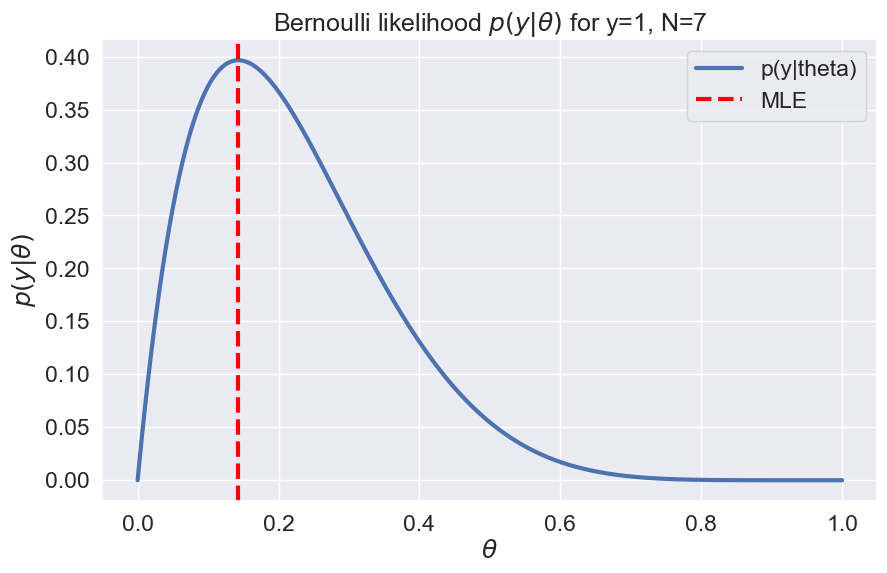

In [3]:
# data
N1 = 7
y1 = 1

# make grid for plotting the likelihood p(y|theta) in interval [0, 1]
thetas = jnp.linspace(0, 1, 1000)

# likelihood from the library
likelihood_library = binom_dist.pmf(y1, N1, thetas)

# likelihood implemented
likelihood_implemented = bernoulli_likelihood(y1, N1, thetas)

# assert likelihood from the library and the implemented likelihood are the same
assert jnp.allclose(likelihood_library, likelihood_implemented)

# find the MLE

theta_MLE = bernoulli_MLE(y1, N1)

# plot the likelihood
plt.figure(figsize=(10, 6))
plt.plot(thetas, likelihood_library, label='p(y|theta)')
plt.axvline(theta_MLE, color='red', linestyle='--', label='MLE')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(y|\theta)$')
plt.title(r'Bernoulli likelihood $p(y|\theta)$ for y=1, N=7')
plt.legend()
plt.show()


**Task 1.2**: Compute the maximum likelihood estimate for $\theta$ and compute a 95% confidence interval using the equations given above.

I compute the maximum likelihood estimate as: 

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N} = \frac{1}{7} \approx 0.143$$

In [4]:
print("SOLUTION: ")
stars()


# We can calculate the likelihood two ways, we can either use the argmax function 

# MLE estimate for theta by taking the argmax of the likelihood
MLE_easy = jnp.argmax(likelihood_implemented)
print(rf"MLE estimate for $\theta$ is (finding the maximum) {thetas[MLE_easy]:.4f}")

MLE_implemented = bernoulli_MLE(y1, N1)
print(rf"MLE estimate for $\theta$ (from an equation) is {MLE_implemented:.4f}")

# assert the two ways of calculating the MLE are the same
assert jnp.isclose(thetas[MLE_easy], MLE_implemented, atol=1e-3)


# Calculate confidence intervals
lower, upper = confidence_intervals(MLE_implemented, N1)

print(rf"Confidence intervals for $\theta$ are [{lower:.4f}, {upper:.4f}]")

stars()

SOLUTION: 
****************************************************************************************************
MLE estimate for $\theta$ is (finding the maximum) 0.1431
MLE estimate for $\theta$ (from an equation) is 0.1429
Confidence intervals for $\theta$ are [-0.1164, 0.4021]
****************************************************************************************************


#### Plotting the likelihood and the confidence intervals

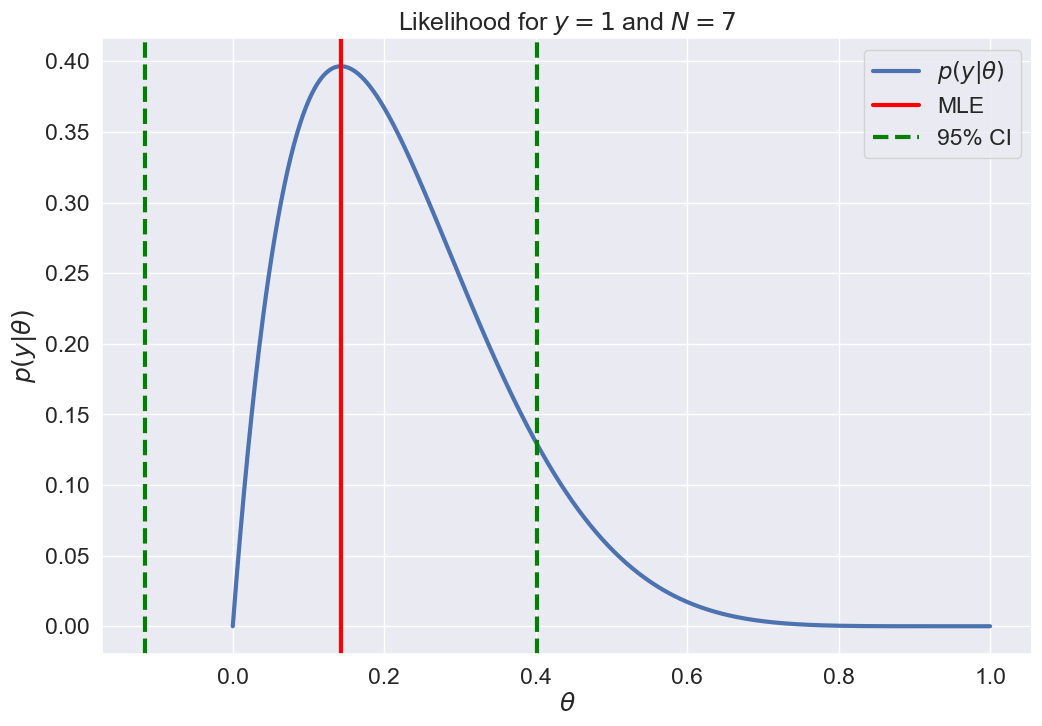

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(thetas, likelihood_implemented, label=r'$p(y|\theta)$')
plt.axvline(MLE_implemented, color='red', label='MLE')
plt.axvline(upper, color='green', linestyle='--', label='95% CI')
plt.axvline(lower, color='green', linestyle='--')
plt.title(rf'Likelihood for $y={y1}$ and $N={N1}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(y|\theta)$')
plt.legend()
plt.show()


**Task 1.3**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

***Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.**

MLE estimate for $\theta$ is (finding the maximum) 0.0000
MLE estimate for $\theta$ (from an equation) is 0.0000


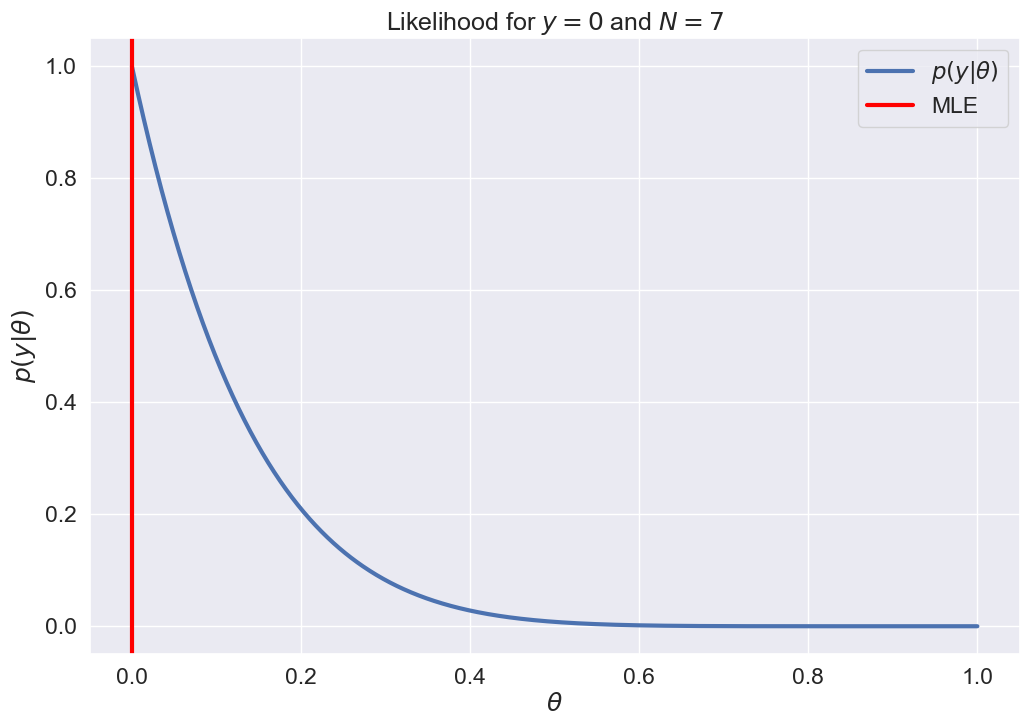

In [6]:
# data
N0 = 7
y0 = 0

# make grid for plotting the likelihood p(y|theta) in interval [0, 1]
thetas_0 = jnp.linspace(0, 1, 1000)

# likelihood from the library
likelihood_library_0 = binom_dist.pmf(y0, N0, thetas_0)

# likelihood implemented
likelihood_implemented_0 = bernoulli_likelihood(y0, N0, thetas_0)

# assert likelihood from the library and the implemented likelihood are the same
assert jnp.allclose(likelihood_library_0, likelihood_implemented_0)


# We can calculate the likelihood two ways, we can either use the argmax function 

MLE_easy_0 = jnp.argmax(likelihood_implemented_0)
print(rf"MLE estimate for $\theta$ is (finding the maximum) {thetas_0[MLE_easy_0]:.4f}")

MLE_implemented_0 = bernoulli_MLE(y0, N0)
print(rf"MLE estimate for $\theta$ (from an equation) is {MLE_implemented_0:.4f}")

# assert the two ways of calculating the MLE are the same
assert jnp.isclose(thetas_0[MLE_easy_0], MLE_implemented_0, atol=1e-3)



plt.figure(figsize=(12, 8))
plt.plot(thetas_0, likelihood_implemented_0, label=r'$p(y|\theta)$')
plt.axvline(MLE_implemented_0, color='red', label='MLE')
plt.title(rf'Likelihood for $y={y0}$ and $N={N0}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(y|\theta)$')
plt.legend()
plt.show()


# Part 2:  Bayesian inference

We will now turn our attention towards Bayesian inference for $\theta$. Recall, the core concept of Bayesian inference is that we infer a **full probability distribution**  for $\theta$ rather than just a **point estimate** like $\hat{\theta}_{MLE}$. 
As before, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$, but now we assume a **uniform prior distribution** for $\theta$, i.e. $p(\theta) = \text{Beta}(\theta|a_0,b_0) = 1$ for $a_0 = b_0 = 1$.

**Task 2.1**: Compute the **prior** mean and variance of $\theta$, i.e. the mean and variance of $p(\theta)$.


We use the equation on slide 37 in the lecture notes to compute the mean and variance of the Beta distribution.

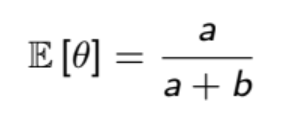

Calculating the mean of the Beta distribution:
$$
\begin{align*}
\mathbb{E}\left[\theta\right] &= \frac{a_0}{a_0+b_0} \\
&= \frac{1}{1+1} && \text{(Plugging in $a_0 = 1$ and $b_0 = 1$)} \\
&= \frac{1}{2} = 0.5
\end{align*}
$$

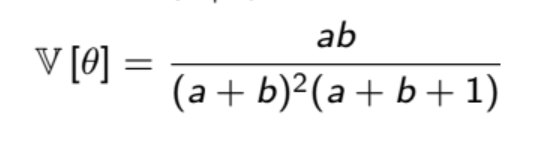

Calculating the variance of the Beta distribution:
$$
\begin{align*}
\mathbb{V}\left[\theta\right] &= \frac{a_0 b_0}{(a_0+b_0)^2(a_0+b_0+1)} \\
&= \frac{1 \cdot 1}{(1+1)^2(1+1+1)} && \text{(Plugging in $a_0 = 1$ and $b_0 = 1$)} \\
&= \frac{1}{4 \cdot 3} \\
&= \frac{1}{12} = 0.0833
\end{align*}
$$

In [7]:
# uniform prior for theta, i.e. p(theta) = Beta(theta|a_0, b_0) = 1 for a_0 = b_0 = 1
a_0, b_0 = 1, 1

# mean of a beta distribution is E[theta] = a / (a + b)
mean_theta = a_0 / (a_0 + b_0)

# variance of a beta distribution is Var[theta] = a * b / (jnp.pow(a + b, 2) * (a + b + 1))
sigma_theta = a_0 * b_0 / (jnp.pow(a_0 + b_0, 2) * (a_0 + b_0 + 1.0))

print("SOLUTION: ")
stars()
print("The mean of the prior distribution E[theta] is ", mean_theta)
print("The variance of the prior distribution Var[theta] is ", sigma_theta)
stars()

SOLUTION: 
****************************************************************************************************
The mean of the prior distribution E[theta] is  0.5
The variance of the prior distribution Var[theta] is  0.083333336
****************************************************************************************************


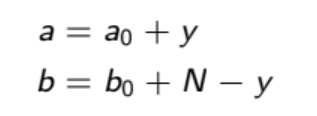

**Task 2.2**: Compute the parameters $a$ and $b$ of the posterior distribution, i.e. $p(\theta|y)$, using the equations for the Beta-binomial model.


Computing the parameters of the posterior distribution:

$$
\begin{align*}
a &= a_0 + y = 1 + 1 = 2 \\
b &= b_0 + N - y = 1 + 7 - 1 = 7
\end{align*}
$$




In [8]:
# Defining what we know. We have total 7 trials and number of sucesses is 1 
N = 7 
y = 1 

# a parameter for the posterior distribution is another Beta distribution with parameters 
# a = a_0 + y 
a = a_0 + y 

print("SOLUTION: ")
stars()
print(f"Parameter a for the posterior distribution is {a}")

# b parameter for the posterior distributon is another Beta distributions with parameters 
# b = b_0 + N + y 
b = b_0 + N - y 
print(f"Parameter b for the posterior distribution is {b}")
stars()


SOLUTION: 
****************************************************************************************************
Parameter a for the posterior distribution is 2
Parameter b for the posterior distribution is 7
****************************************************************************************************


**Task 2.3**: Plot the prior density $p(\theta)$, likelihood $p(y|\theta)$, and the posterior density $p(\theta|y)$ as a function of $\theta$ for $\theta \in \left[0, 1\right]$ in the same figure.

*Hints: the functions beta_dist.pdf and binom_dist.pmf might come in handy*

**Notes**: 

PMF (Probability Mass Function) is for discrete distributions (Binomial, Poisson). It gives exact probabilities.

PDF (Probability Density Function) is for continuous distributions (Normal, Beta). It gives density, and probability requires integration.


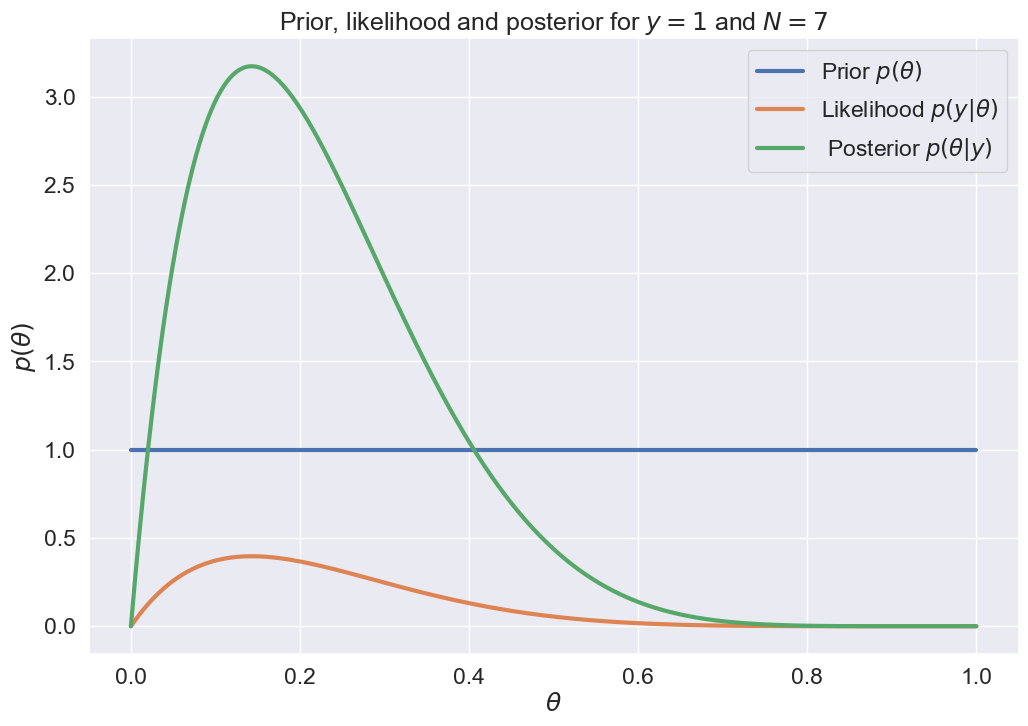

In [9]:
# make grid for plotting the prior, likelihood and posterior in interval [0, 1]
thetas = jnp.linspace(0, 1, 1000)

# prior distribution p(theta)
beta_prior = beta_dist.pdf(thetas, a_0, a_0)

# likelihood distribution p(y|theta)
beta_likelihood = binom_dist.pmf(y, N, thetas)

# posterior distribution (beta distribution) p(theta|y)
beta_posterior = beta_dist.pdf(thetas, a, b)

# plot the prior, likelihood and posterior
plt.figure(figsize=(12, 8))
plt.plot(thetas, beta_prior, label=r'Prior $p(\theta)$')
plt.plot(thetas, beta_likelihood, label=r'Likelihood $p(y|\theta)$')
plt.plot(thetas, beta_posterior, label=r' Posterior $p(\theta|y)$')
plt.title(rf'Prior, likelihood and posterior for $y={y}$ and $N={N}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend()
plt.show()


**Task 2.4**: Compute the **MAP-estimator** for $\theta$ as well as the posterior mean of $\theta$. 

*Hint*: *The MAP-estimator is the mode of the posterior density, i.e. $\theta_{\text{MAP}} = \arg\max\limits_{\theta \in \left[0, 1\right]} p(\theta|y)$*, and can be computed analytically for the Beta-binomoial model.

In [10]:
# MAP estimator 

#MAP_theta_2 = jnp.argmax(beta_posterior)
MAP_theta = (a - 1) / (a + b - 2)

# Alternative equation for MAP estimator
#MAP_theta_longer = (a_0 + y - 1) / (a_0 + b_0 + N - 2)


print("SOLUTION: ")
stars()
#print(f"MAP estimate for theta is: {MAP_theta:.4f}")
print(f"Second MAP = {MAP_theta:.4f}")

# posterior mean 
post_mean_theta = a / (a + b)
print(f"Posterior mean E[theta|y] for theta is: {post_mean_theta:.4f}")
stars()


SOLUTION: 
****************************************************************************************************
Second MAP = 0.1429
Posterior mean E[theta|y] for theta is: 0.2222
****************************************************************************************************


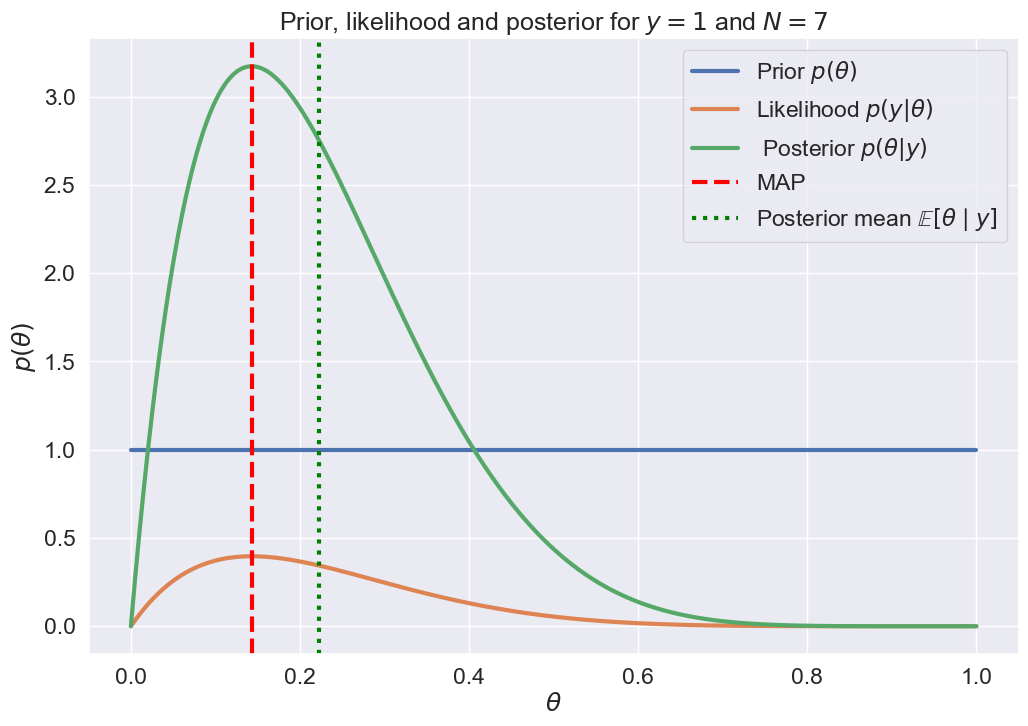

In [11]:
# plot the prior, likelihood and posterior
plt.figure(figsize=(12, 8))
plt.plot(thetas, beta_prior, label=r'Prior $p(\theta)$')
plt.plot(thetas, beta_likelihood, label=r'Likelihood $p(y|\theta)$')
plt.plot(thetas, beta_posterior, label=r' Posterior $p(\theta|y)$')
plt.axvline(MAP_theta, color='red', label='MAP', linestyle='--')
plt.axvline(post_mean_theta, color='green', linestyle=':', label=r'Posterior mean $\mathbb{E}[\theta \mid y]$')
plt.title(rf'Prior, likelihood and posterior for $y={y}$ and $N={N}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend()
plt.show()


**Task 2.5**: Compute a 50%, 90% and a 95% posterior credibility interval for $\theta$.

*Hints*:
-  To obtain a 50% posterior credibility interval, our goal is to identify $\theta_1, \theta_2 \in \left[0, 1\right]$ such that  $p(\theta \in \left[\theta_1, \theta_2\right]|\mathcal{D}) = \int _{\theta_1}^{\theta_2} p(\theta|\mathcal{D}) \text{d} \theta  \approx 0.5$
- *scipy.stats.beta.interval* might come in handy for this.

In [12]:
intervals = [0.5, 0.9, 0.95]

for interval in intervals:
    lower, upper = beta_dist.interval(interval, a, b)
    print(f"{interval * 100}% CI: ({lower:.4f}, {upper:.4f})")


50.0% CI: (0.1206, 0.3027)
90.0% CI: (0.0464, 0.4707)
95.0% CI: (0.0319, 0.5265)


**Task 2.6**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*


MAP estimate theta: 0.0000
Posterior mean theta: 0.1111


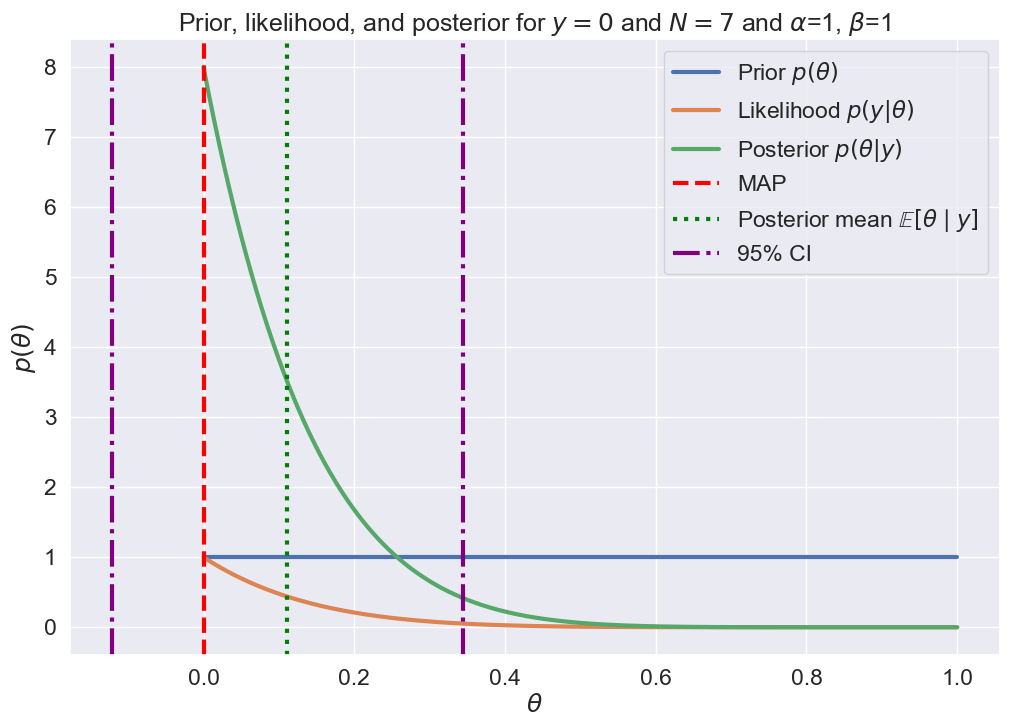

In [13]:
task_2_6 = plot_bayesian_inference(0, 7, a_0, b_0)

**Task 2.7**: Experiment with different values of $a_0$, $b_0$, $N$, and $y$ to explore how it affects the results (e.g. the plots, MAP, posterior mean and posterior credibility interval).

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*

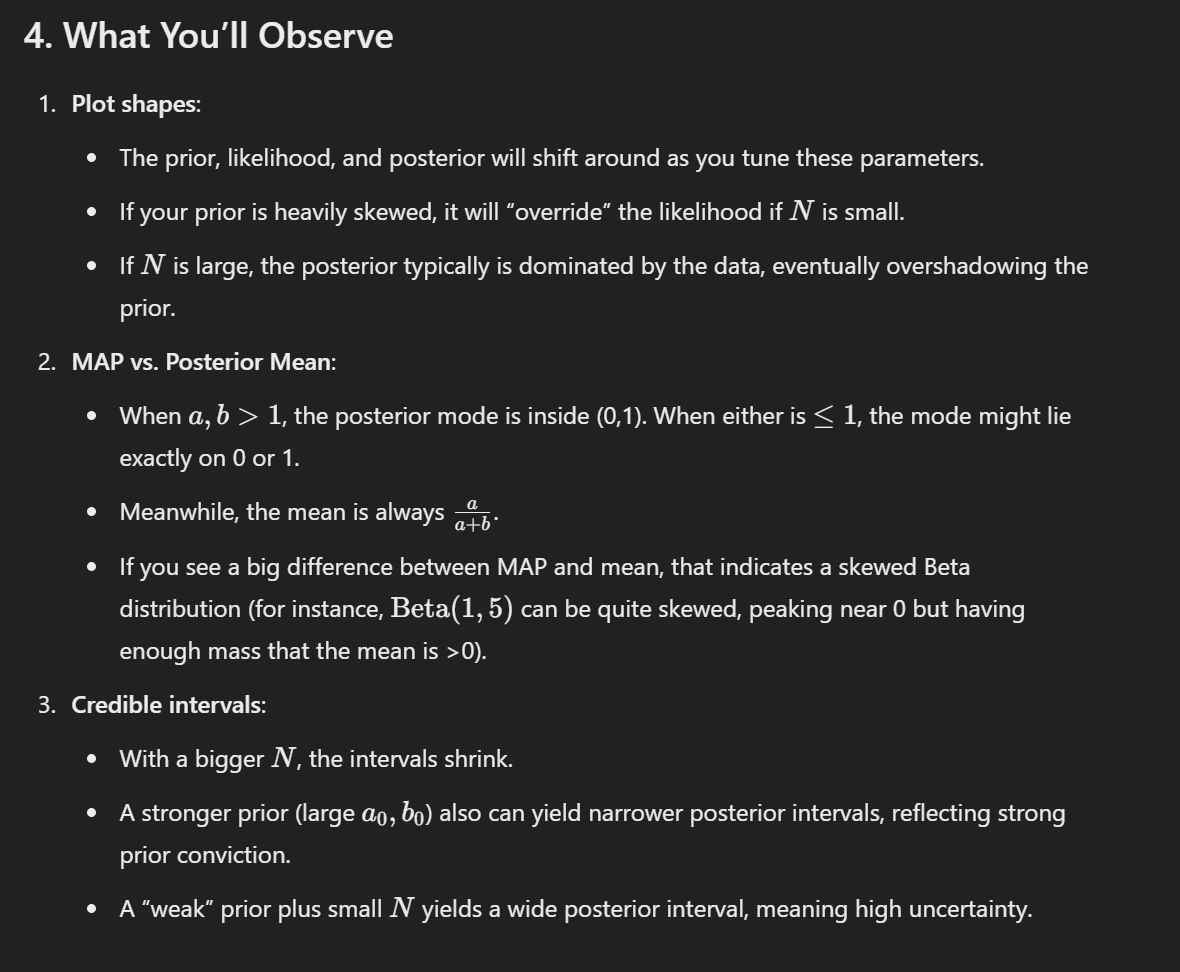


**Task 2.7.1 Exp 1 larger $\alpha$ then $\beta$**

MAP estimate theta: 0.6246
Posterior mean theta: 0.6111


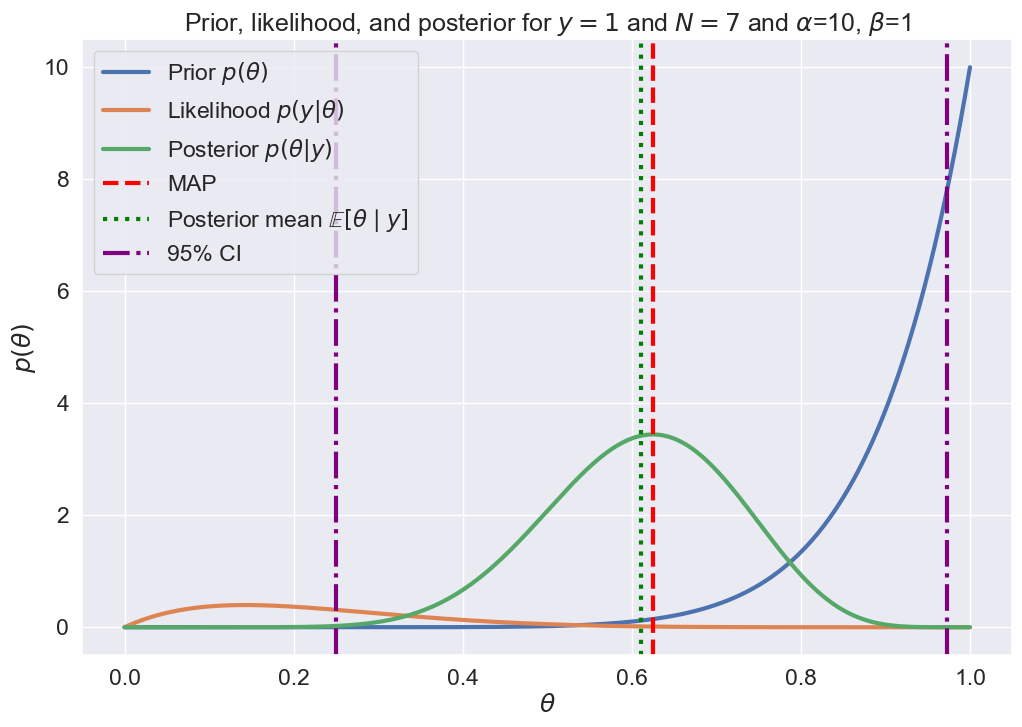

In [14]:
exp_1 = plot_bayesian_inference(1, 7, 10, 1)

**Task 2.7.2 Larger $\beta$ than $\alpha$**

MAP estimate theta: 0.0621
Posterior mean theta: 0.1111


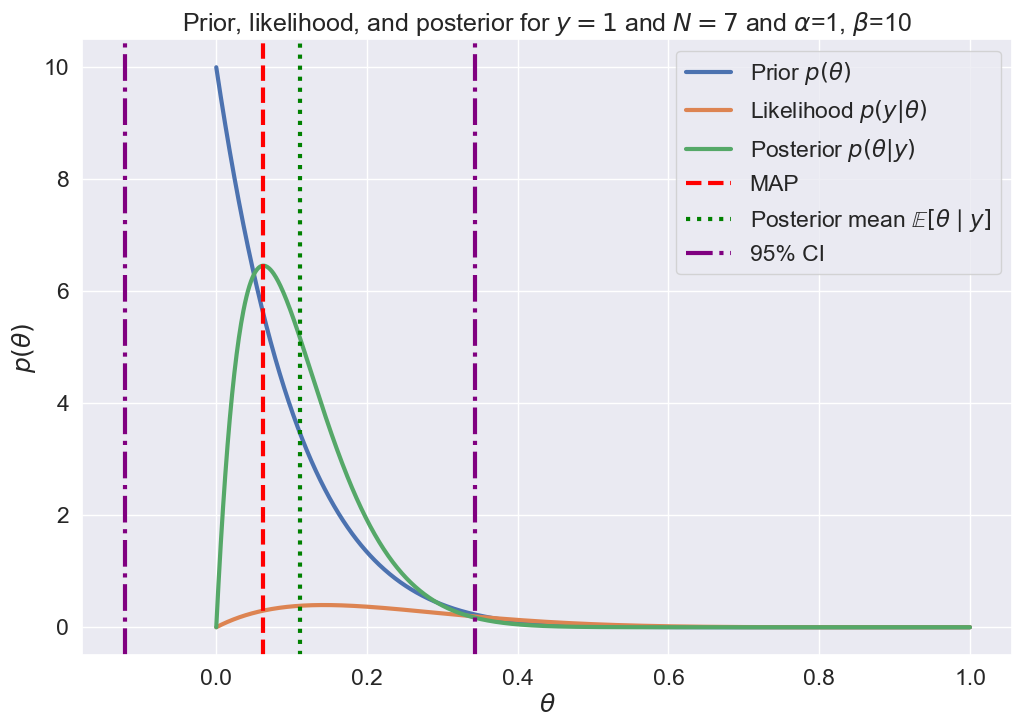

In [15]:
exp_1 = plot_bayesian_inference(1, 7, 1, 10)

**Task 2.7.3 exp 3 alpha and beta are the same (high)**

MAP estimate theta: 0.4004
Posterior mean theta: 0.4074


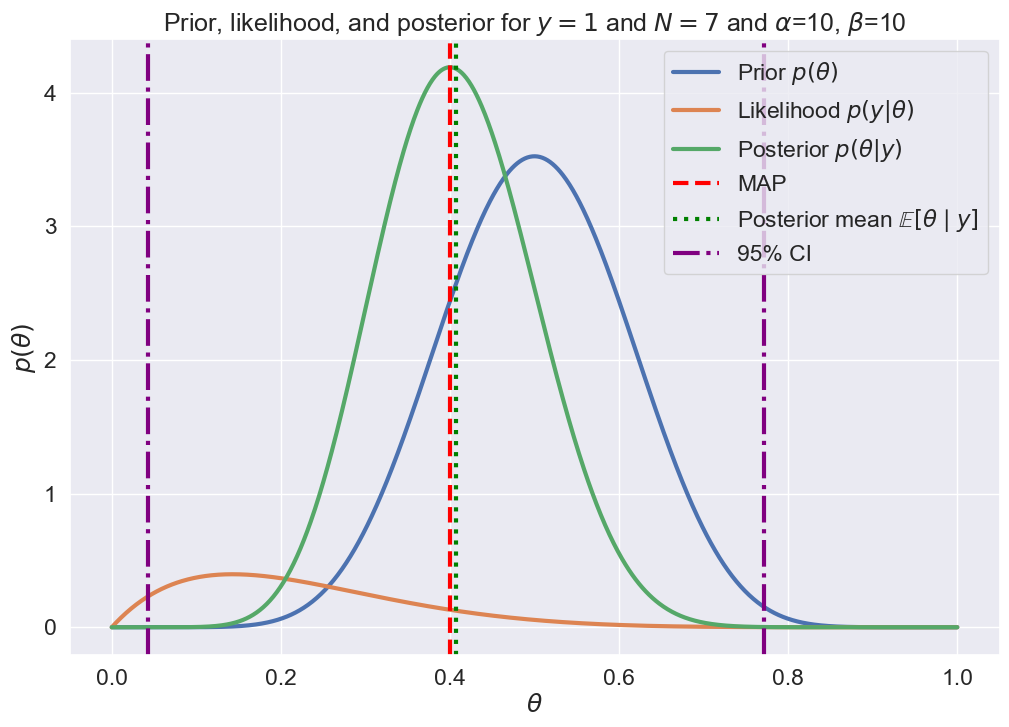

In [16]:
# exp 3 both alpha and beta are the same (high)
exp_3 = plot_bayesian_inference(1, 7, 10, 10)

**Task 2.7.3 exp 4 alpha and beta are the same (low)**

MAP estimate theta: 0.1431
Posterior mean theta: 0.2222


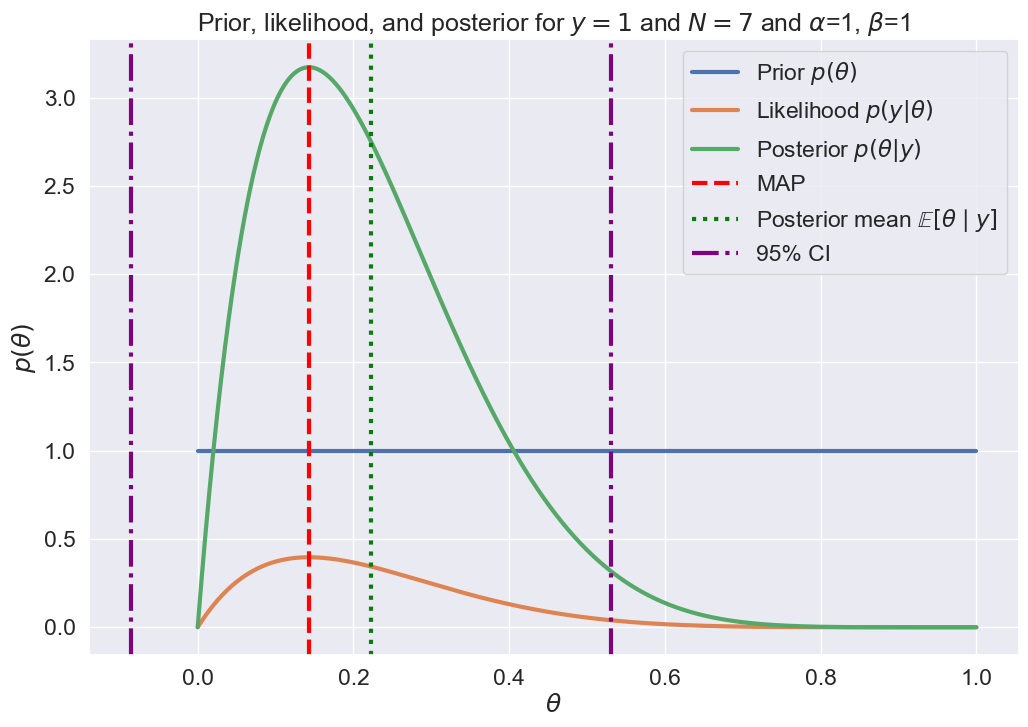

In [17]:
exp_4 = plot_bayesian_inference(1, 7, 1, 1)

**Task 2.7.5 y = 3, N=10, I will vary beta and alpha from (1,1), (10,10) and (0.5, 0.5) respecively**

MAP estimate theta: 0.3003
Posterior mean theta: 0.3333


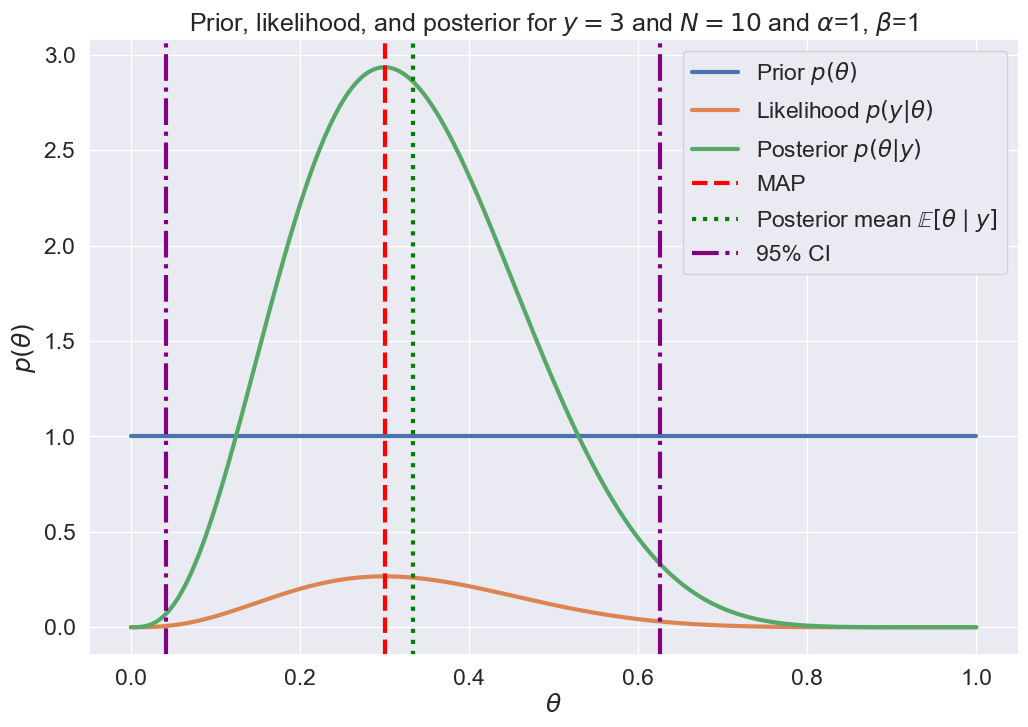

MAP estimate theta: 0.4284
Posterior mean theta: 0.4333


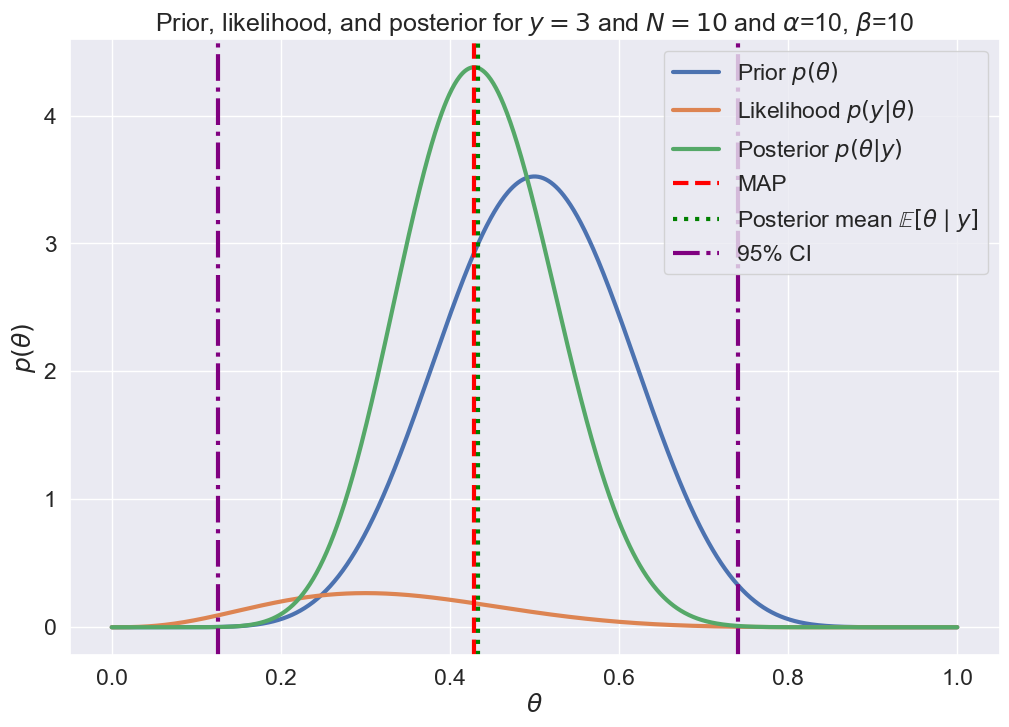

MAP estimate theta: 0.2783
Posterior mean theta: 0.3182


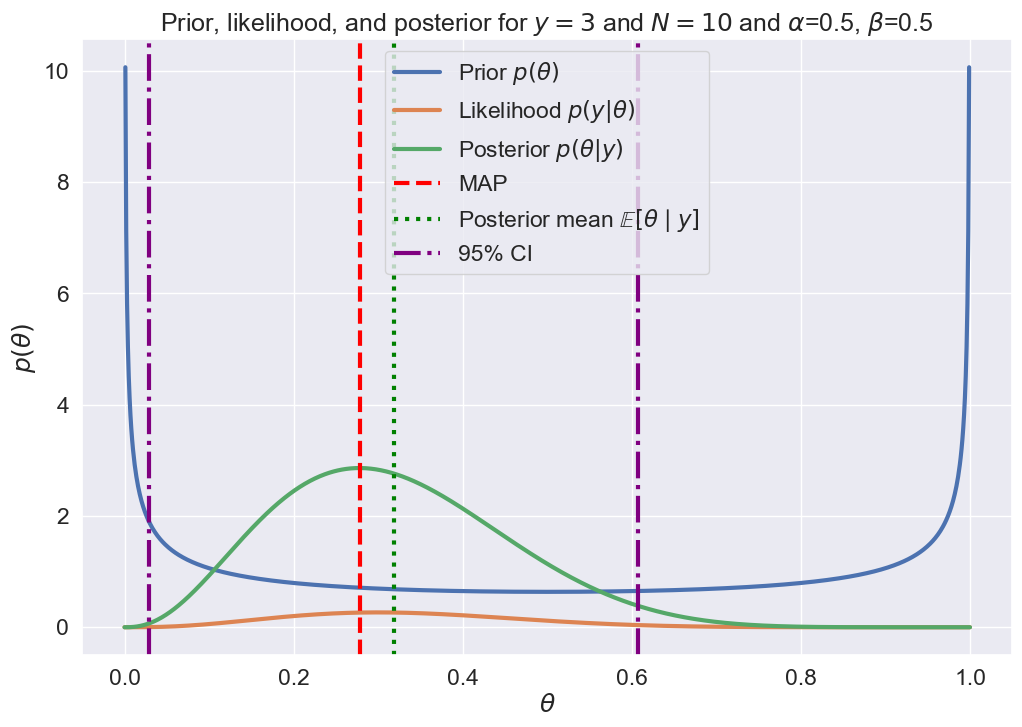

In [18]:
task5_1 = plot_bayesian_inference(3, 10, 1, 1)

task5_2 = plot_bayesian_inference(3, 10, 10, 10)

task5_3 = plot_bayesian_inference(3, 10, 0.5, 0.5)

**Task 2.7.6 alph=1, beta=1, N = 7, I will vary Number of sucesses y respecively**

MAP estimate theta: 0.0000
Posterior mean theta: 0.1111


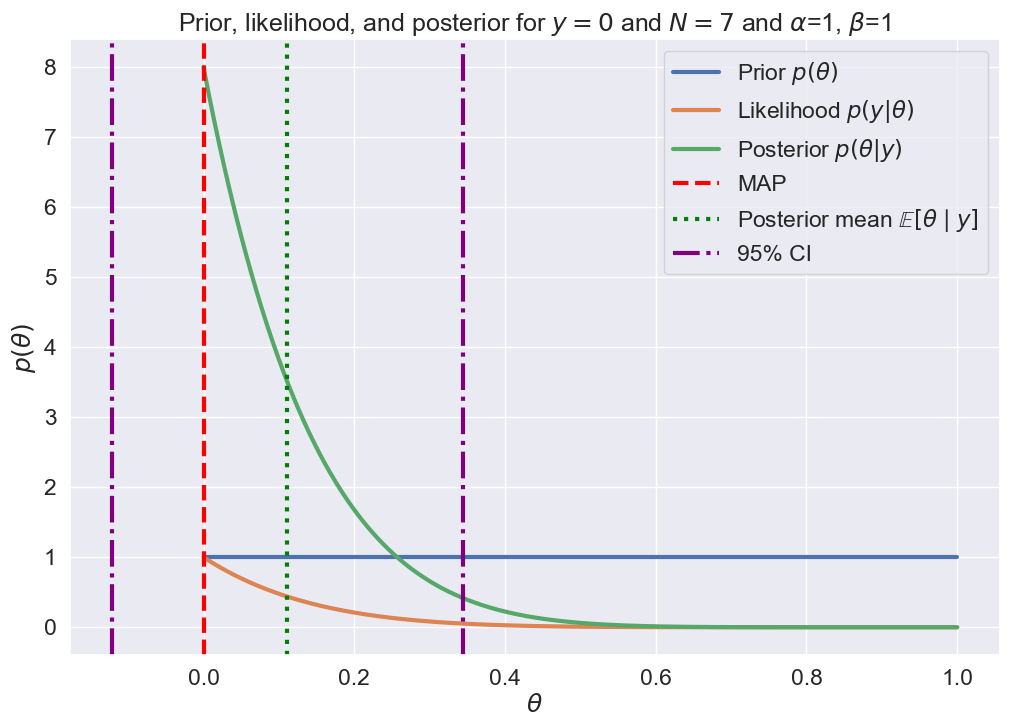

MAP estimate theta: 0.1431
Posterior mean theta: 0.2222


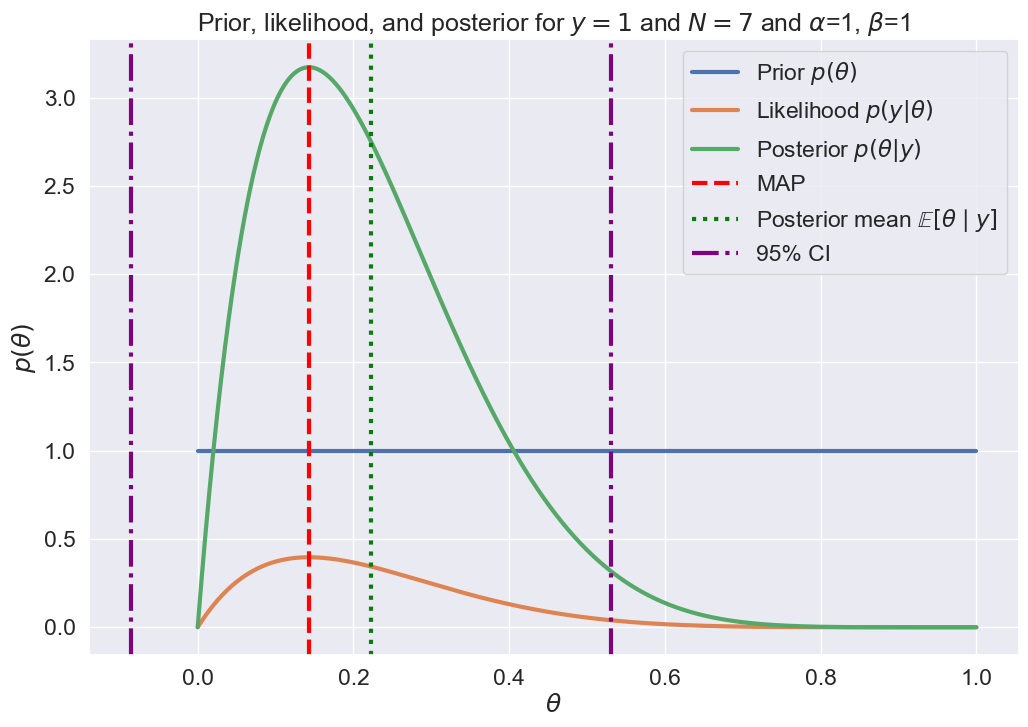

MAP estimate theta: 1.0000
Posterior mean theta: 0.8889


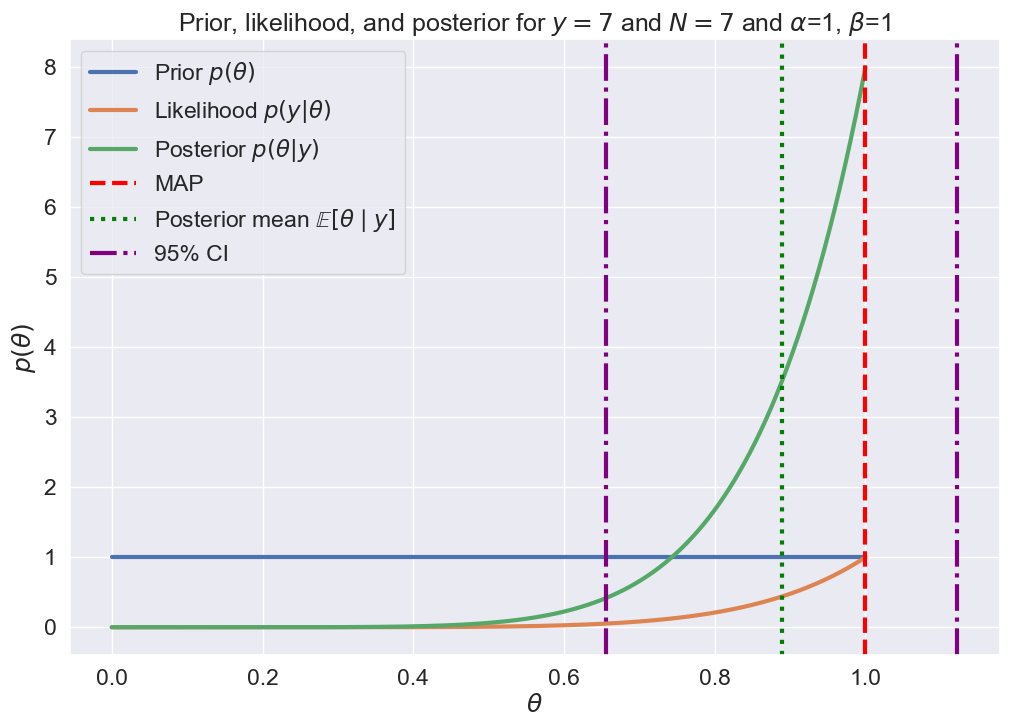

In [19]:
task6_1 = plot_bayesian_inference(0, 7, 1, 1)
task6_2 = plot_bayesian_inference(1, 7, 1, 1)
task6_3 = plot_bayesian_inference(7, 7, 1, 1)

**Task 2.7.7 alph=1, beta=1, N = 7, I will vary Number of trials N respecively and then beta=10 and alpha = 10 with same y and N**

MAP estimate theta: 0.1431
Posterior mean theta: 0.2222


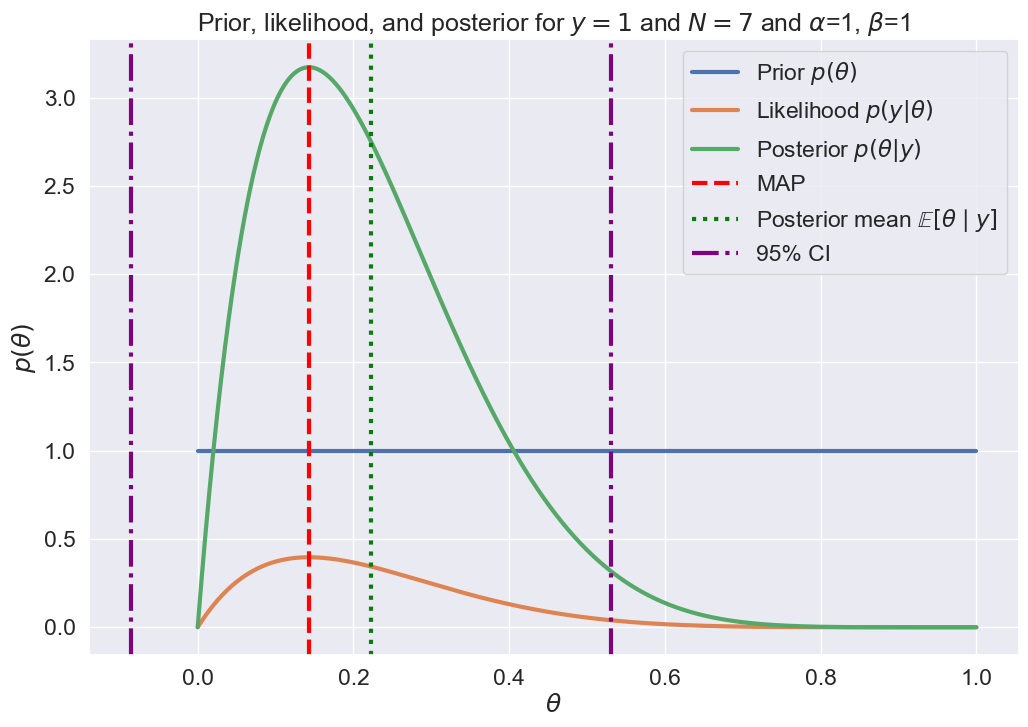

MAP estimate theta: 0.4004
Posterior mean theta: 0.4074


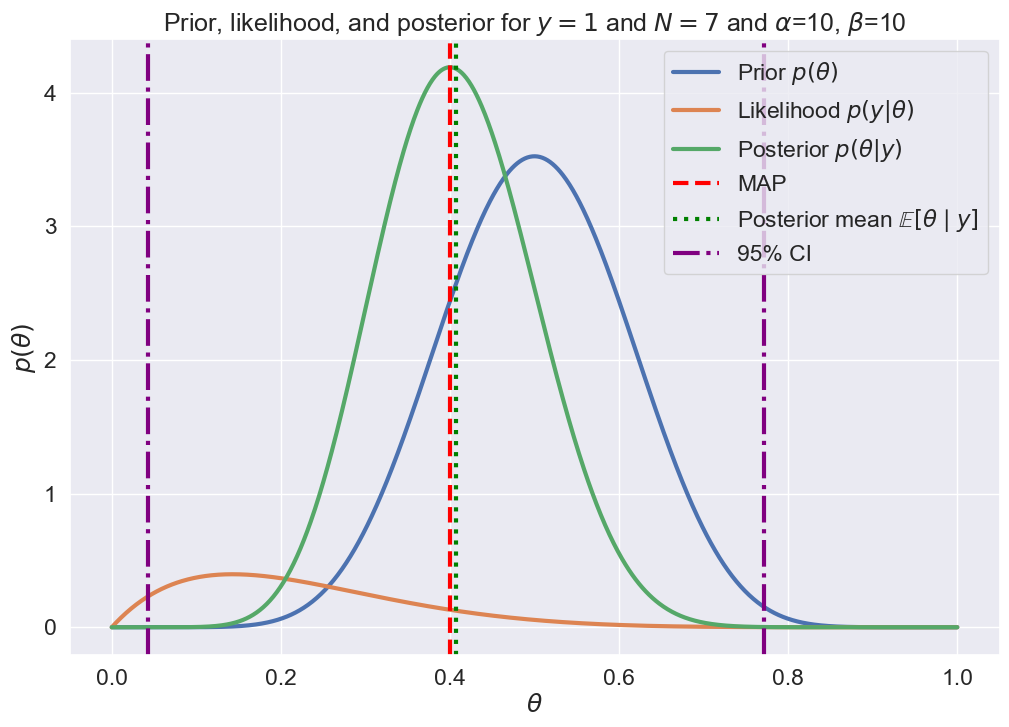

In [20]:
task7_1 = plot_bayesian_inference(1, 7, 1, 1)

task7_2 = plot_bayesian_inference(1, 7, 10, 10)

**Task 2.7.8 Beta = 1, Alpha = 1, N = 7 and y = 0** 
- Beta prior (1,1) with y = 0, N = 7
- -> Posterior (1, 8)

MAP estimate theta: 0.0000
Posterior mean theta: 0.1111


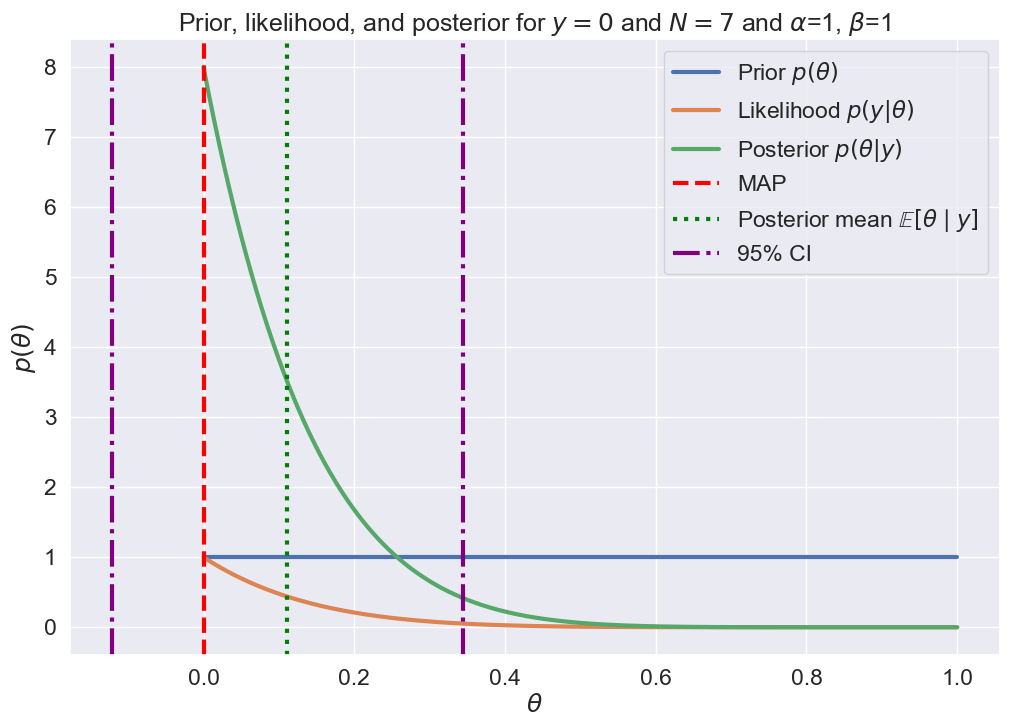

In [21]:
exp_8 = plot_bayesian_inference(0, 7, 1, 1)

**Task 2.7.9 Beta = 10, Alpha = 1, N = 7 and y = 0** 
- Beta prior (10,1) with y = 0, N = 7
- -> Posterior (10, 8)

MAP estimate theta: 0.5626
Posterior mean theta: 0.5556


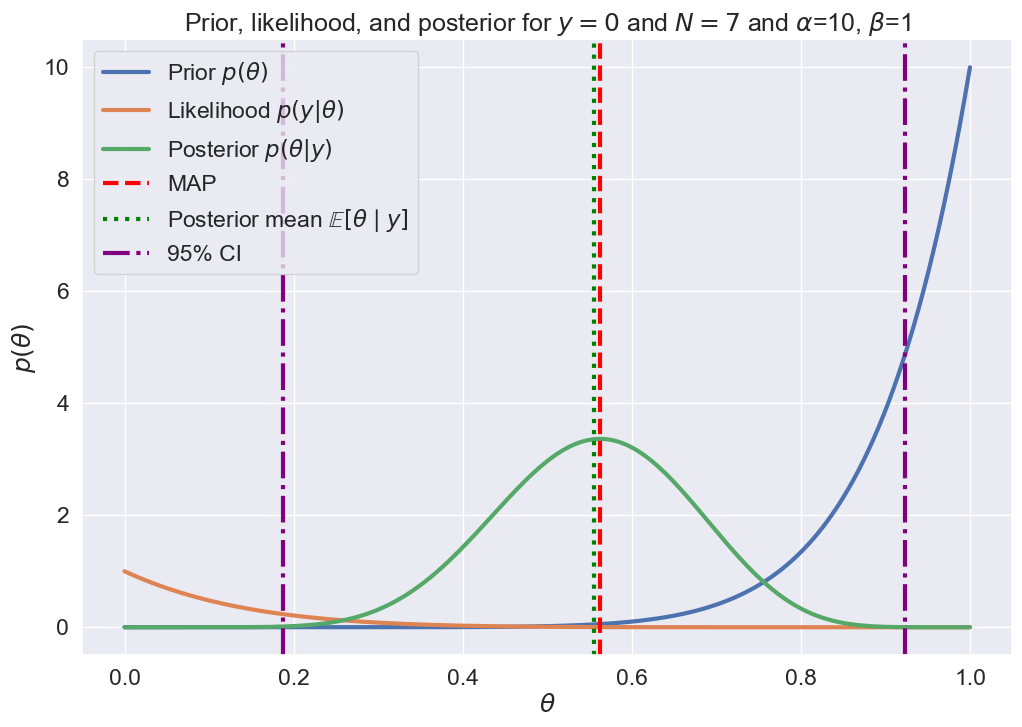

In [22]:
exp_9 = plot_bayesian_inference(0, 7, 10, 1)

**Task 2.7.10 Beta = 1, Alpha = 1, N = 50 and y = 10** 
- Beta prior (1,1) with y = 0, N = 7
- -> Posterior (10, 41)

MAP estimate theta: 0.2002
Posterior mean theta: 0.2115


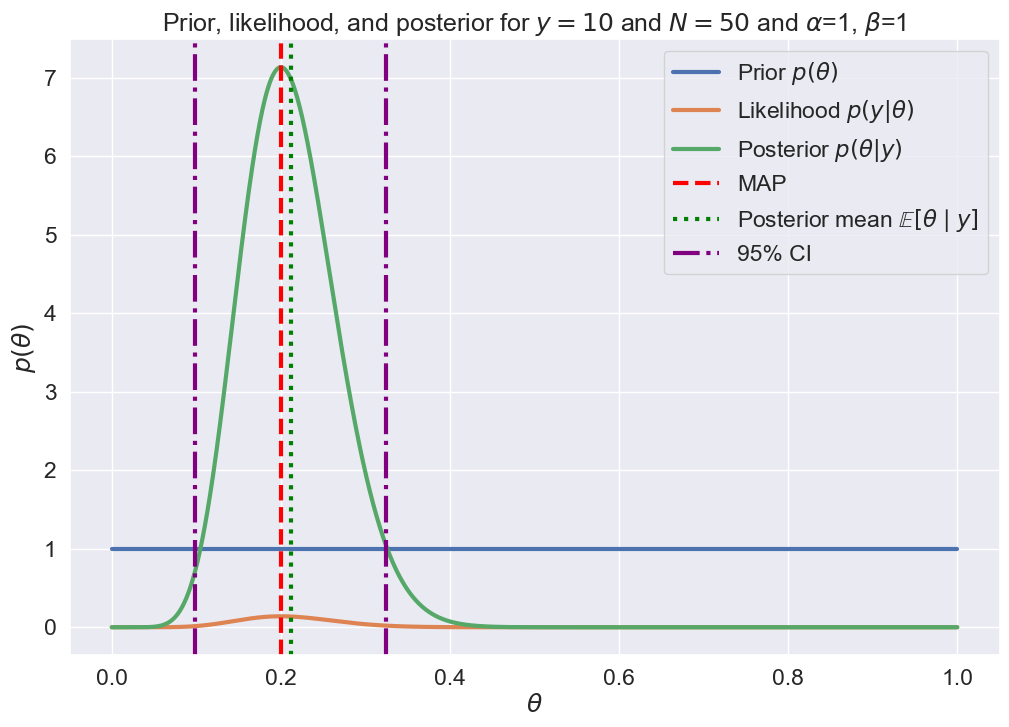

In [23]:
exp_10 = plot_bayesian_inference(10, 50, 1, 1)

**Task 2.7.8 Beta = 10, Alpha = 10, N = 50 and y = 10** 
- Beta prior (10,10) with y = 10, N = 50
- -> Posterior (20, 50)

MAP estimate theta: 0.2793
Posterior mean theta: 0.2857


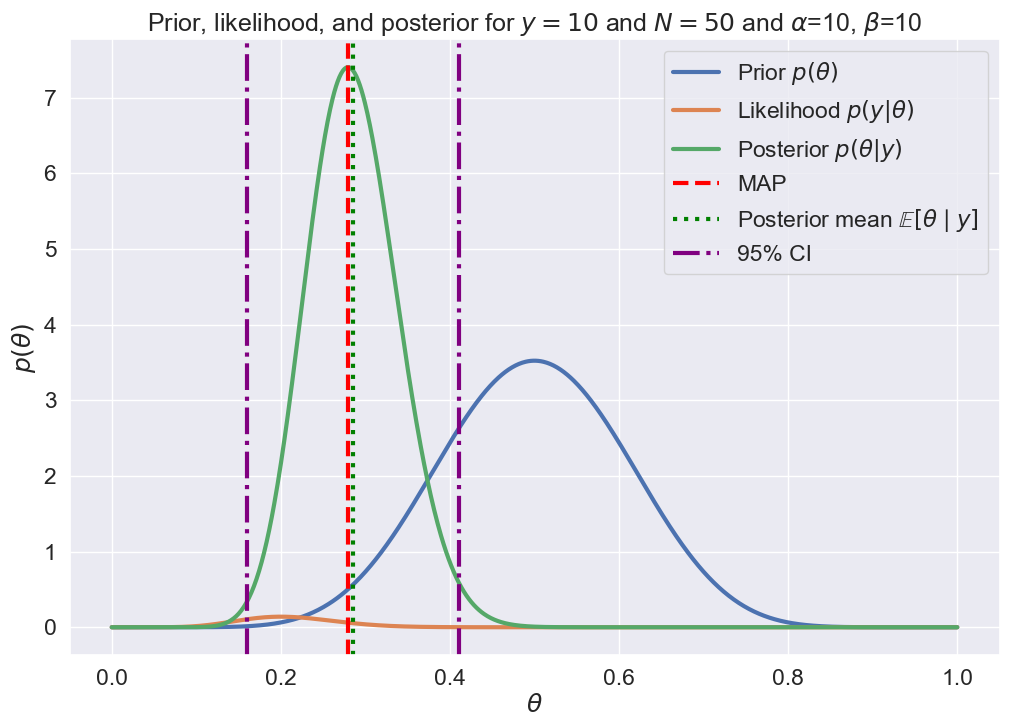

In [24]:
exp_11 = plot_bayesian_inference(10, 50, 10, 10)

In the next few tasks, we will explore the relationships between the posterior mean and the maximum likelihood estimator.

**Task 2.8** Show that the posterior mean converges to the maximum likelihood estimator $\hat{\theta}_{\text{MLE}} = \frac{y}{N}$ as $N \rightarrow \infty$.

*Hints:*
- *Write the posterior mean as a function of $a_0, b_0, N, y$*
- *Write the number of successes as $y = \hat{\theta}_{MLE} N$ and substitute it into the expression for the posterior mean*
- *If you are stuck, don't hesitate to consult the solution or ask the teachers/teaching assistant for an additional hint*





**Task 2.9** Show that the posterior mean is always between the prior mean, $\theta_0 = \frac{a_0}{a_0 + b_0}$, and the maximum likelihood estimate $\hat{\theta}_{MLE} = \frac{y}{N}$.

Hints:
- Show that the posterior mean is a convex combination of the prior mean $\theta_0$ and the maximum likelihood solution $\hat{\theta}_{\text{MLE}}$, i.e. that the posterior mean can be written as 

$$
\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = (1-\lambda) \theta_0 + \lambda \hat{\theta}_{MLE}
\end{align*}
$$
for some $0 \leq \lambda \leq 1$.





# Part 3:  The functional form of Beta distributions

Suppose you are given the expression for a probability density function $p_d(\theta)$ up to a constant, i.e. you are told that $p_d(\theta) =   \frac{1}{Z_d}\theta^{36}(1-\theta)^{41}$, where $Z_d > 0$ is an unknown, but positive constant.

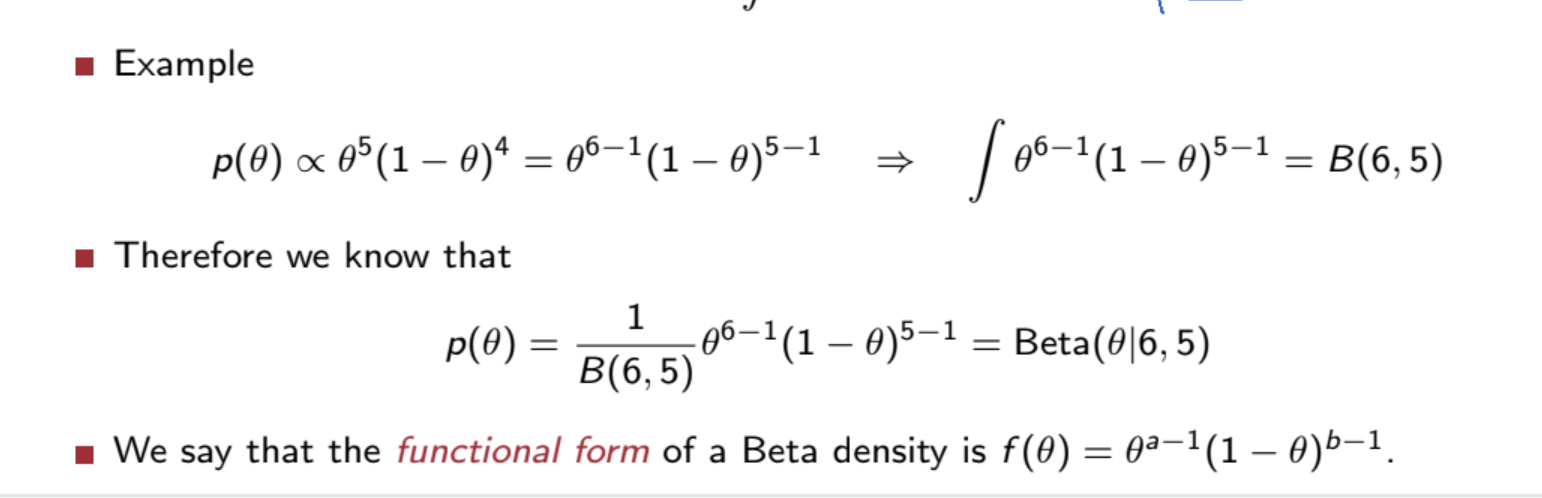


**Task 3.1**: Argue the distribution $p_d$ specified above must be a Beta-distribution $p(\theta|a_d, b_d)$ and identify its parameters $a_d, b_d$.

We recognize the functional form of the slides of the Beta distributon. We find the parameters as follows:

$$
\begin{align*}
p_d(\theta) &=   \frac{1}{Z_d}\theta^{36}(1-\theta)^{41} \\
            &=   \frac{1}{Z_d}\theta^{37 - 1}(1-\theta)^{42 - 1}
\end{align*}
$$

Therefore the parameters of the Beta distribution are $a_d = 37$ and $b_d = 42$.




**Task 3.2**: Compute $Z_d$

*Hint: What is the normalization constant for a Beta distribution?*




We will now use our knowledge of the functional form for Beta densities to compute the denominator in Bayes' theorem, $p(y)$, which is often called the **model evidence** or the **marginal likelihood**. It can be expressed using the **product rule** and the **sum rule** of probability theory:

$$\begin{align*}
p(y) = \underbrace{\int p(y, \theta) \text{d}\theta}_{\text{sum rule}} = \int \underbrace{p(y|\theta)p(\theta)}_{\text{product rule}} \text{d}\theta .
\end{align*}
$$

Later in the course, we will see that this term can be useful for hyperparameter tuning and model selection. For most models of practical interest, the term will be **intractable** because we cannot solve the integral above analytically.  However, for models like the beta-binomial we actually compute this term in closed-form.

**Task 3.3**: Compute the analytical expression for the  model evidence for the Beta-Binomial model

**Hints**:
- Insert the probability mass function for the binomial likelihood and the probability density function for the beta distribution in the integral given above.
- Use linearity of integrals to "move" constants (wrt. $\theta$) outside the integral
- Identify the resulting integral as the integral of the functional form corresponding to a Beta density.



# Part 4:  Computing summary statistics and probabilities using sampling

Once, we have obtained our posterior distribution of interest, we often compute the relevant **summary statistics** using **sampling** when the quantities can not easily be computed analytically. We can often generate a set of samples to represent the distribution and then compute the quantities of interest based on the samples. For example,



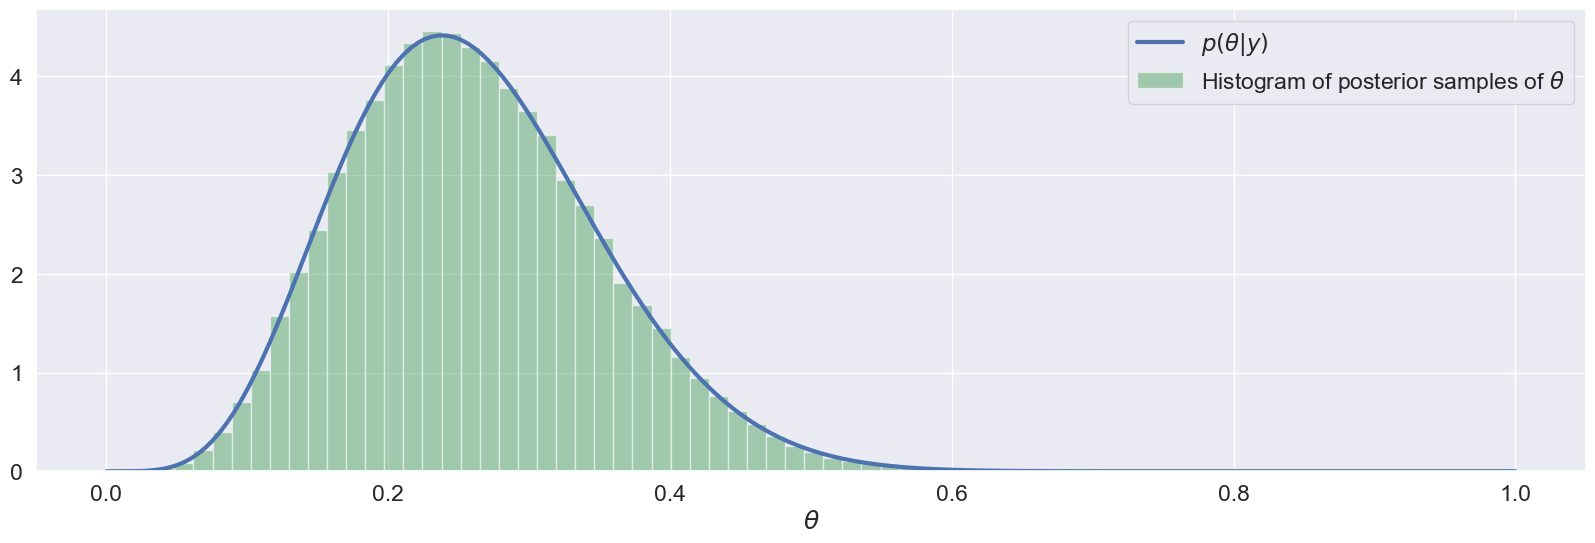

In [25]:
# specify parameters for posterior distribution
a = 6
b = 17

# generate samples
num_samples = 100000
theta_samples = beta_dist.rvs(a=a, b=b, size=num_samples)

# plot
thetas = jnp.linspace(0, 1, 200)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(thetas, beta_dist.pdf(thetas, a=a, b=b), label='$p(\\theta|y)$')
ax.hist(theta_samples, 50, density=True, label='Histogram of posterior samples of $\\theta$', alpha=0.5, color='g')
ax.set(xlabel='$\\theta$')
ax.legend();

Using the posterior samples $\theta^{(i)} \sim p(\theta|y)$ for $i = 1, \dots, S$, we can easily **estimate** the posterior mean and variance:

In [26]:
analytical_posterior_mean = a/(a+b)
analytical_posterior_variance = (a*b)/((a+b)**2*(a+b+1))

print(f'E[theta|D] = {jnp.mean(theta_samples):5.4f} (estimated using samples)')
print(f'E[theta|D] = {analytical_posterior_mean:5.4f} (analytical solution)\n')
print(f'V[theta|D] = {jnp.var(theta_samples):5.4f} (estimated using samples)')
print(f'V[theta|D] = {analytical_posterior_variance:5.4f} (analytical solution)')

E[theta|D] = 0.2612 (estimated using samples)
E[theta|D] = 0.2609 (analytical solution)

V[theta|D] = 0.0080 (estimated using samples)
V[theta|D] = 0.0080 (analytical solution)


Sampling is often easy to implement, and hence, it can also be a highly valuable method for verifying analytical results. 

We can also estimate probabilities and credibility intervals using samples as follows. Suppose we want to estimate the posterior probability that $\theta > 0.2$, then we generate $S$ samples from the posterior, i.e. $\theta^{(i)} \sim p(\theta|\mathcal{D})$ for $i = 1, ..., S$, and then simply count the fraction of samples satisfying $\theta^{(i)} < 0.2$. The reason this works is that we can phrase  the probability as an expectation value, which can be estimated using so-called **Monte Carlo samples**:

$$\begin{align*}
P(\theta > 0.2 | \mathcal{D}) = \int_{0.2}^1 p(\theta|\mathcal{D}) \text{d} \theta = \int_0^1 \mathbb{I}\left[\theta > 0.2\right] p(\theta|\mathcal{D}) \text{d}\theta = \mathbb{E}_{p(\theta|\mathcal{D})}\left[\mathbb{I}\left[\theta > 0.2\right]\right] \approx \frac{1}{S}\sum_{i=1}^S \mathbb{I}\left[\theta^{(i)} > 0.2\right],
\end{align*}$$
where $\mathbb{I}\left[\cdot\right]$ is the indicator function yielding $1$ if the condition in the brackets are true, and 0 otherwise. We will talk much more about Monte Carlo sampling later in the course, but for now, we will simply use it as tool to summarize distributions:

In [27]:
print(f'P[theta > 0.2|D] = {jnp.mean(theta_samples > 0.2):5.4f}\t\t\t(estimated using sampling)\n')

interval = jnp.percentile(theta_samples, jnp.array([2.5, 97.5]))
print(f'95% credibility interval: [{interval[0]:4.3f}, {interval[1]:4.3f}]\t(estimated using sampling)')

P[theta > 0.2|D] = 0.7352			(estimated using sampling)

95% credibility interval: [0.108, 0.454]	(estimated using sampling)


Generally, the larger number of samples $S$ used, the more accurate an estimate we will get. Later in the course, we will make this statement much more precise.

**Example**

A friend of yours is building a classifier for a company, and she asks for your help to evaluate the model. On an independent test set of $N = 100$ examples, the classifier made $y = 8$ errors.  It is critical for the company that the error rate is below 10%. Your friend argues that the error rate is $\frac{8}{100} = 0.08$, so there no need to worry, but you are not as convinced because of the rather small test set.

Let $\theta$ represent the error rate and assume a flat Beta-prior, i.e. $a_0 = b_0 = 1$. 

**Task 4.1**: Compute the posterior mean of the error rate $\theta$.




In [28]:
y_ = 8 
N_ = 100 
a_ = 1 
b_ = 1

a_num = a_ + y_

b_num = b_ + N_ - y_

# print the parameters of the posterior distribution
print(f"Parameters of the posterior distribution are a = {a_num} and b = {b_num}")

posterior_mean =  (a_num) / (a_num + b_num)

# # the posterior mean of the error rate is 
print(f"Posterior mean of the error rate is {posterior_mean:.2f}")


Parameters of the posterior distribution are a = 9 and b = 93
Posterior mean of the error rate is 0.09




**Task 4.2**: Generate $S = 10000$ samples from the posterior distribution and estimate the posterior probability of the test error being larger than $10%$.  Comment on the result.




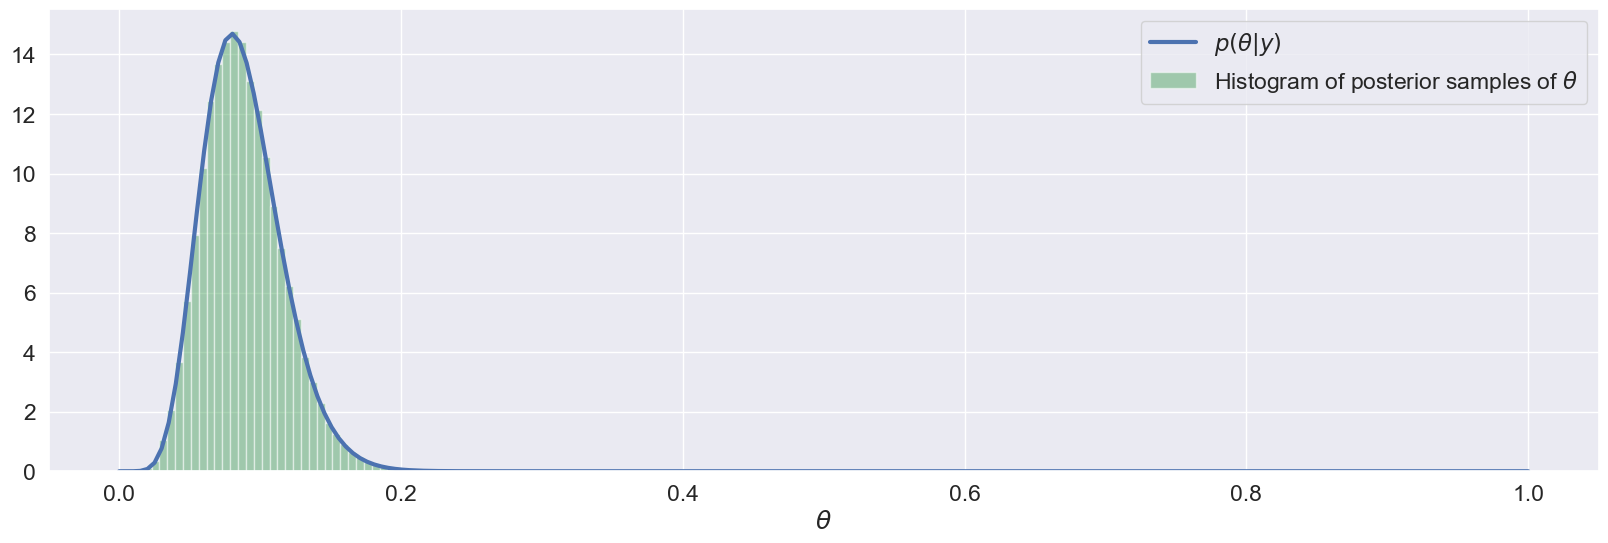

In [29]:

# generate samples
num_samples = 100000
theta_samples = beta_dist.rvs(a=a_num, b=b_num, size=num_samples)

# plot
thetas = jnp.linspace(0, 1, 200)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(thetas, beta_dist.pdf(thetas, a=a_num, b=b_num), label='$p(\\theta|y)$')
ax.hist(theta_samples, 50, density=True, label='Histogram of posterior samples of $\\theta$', alpha=0.5, color='g')
ax.set(xlabel='$\\theta$')
ax.legend();

In [30]:
print(f'P[theta > 0.1|D] = {jnp.mean(theta_samples > 0.1):5.4f}\t\t\t(estimated using sampling)\n')

interval = jnp.percentile(theta_samples, jnp.array([2.5, 97.5]))
print(f'95% credibility interval: [{interval[0]:4.3f}, {interval[1]:4.3f}]\t(estimated using sampling)')

P[theta > 0.1|D] = 0.3100			(estimated using sampling)

95% credibility interval: [0.041, 0.150]	(estimated using sampling)


# Part 5:  Application to A/B testing



Suppose a website has two ads: version A and version B and that version A was shown $N_A = 947$ times and generated $y_A = 87$ clicks, whereas version B was shown $N_B = 1053$ times and generated $y_B = 101$ click.

We will now put everything together and apply it do a Bayesian analysis of the data using the Beta-binomial model. 

**Task 5.1** Assuming a $\text{Beta}(\theta|2, 2)$ prior for both $\theta_A$ and $\theta_B$, plot the posterior density for both ads.

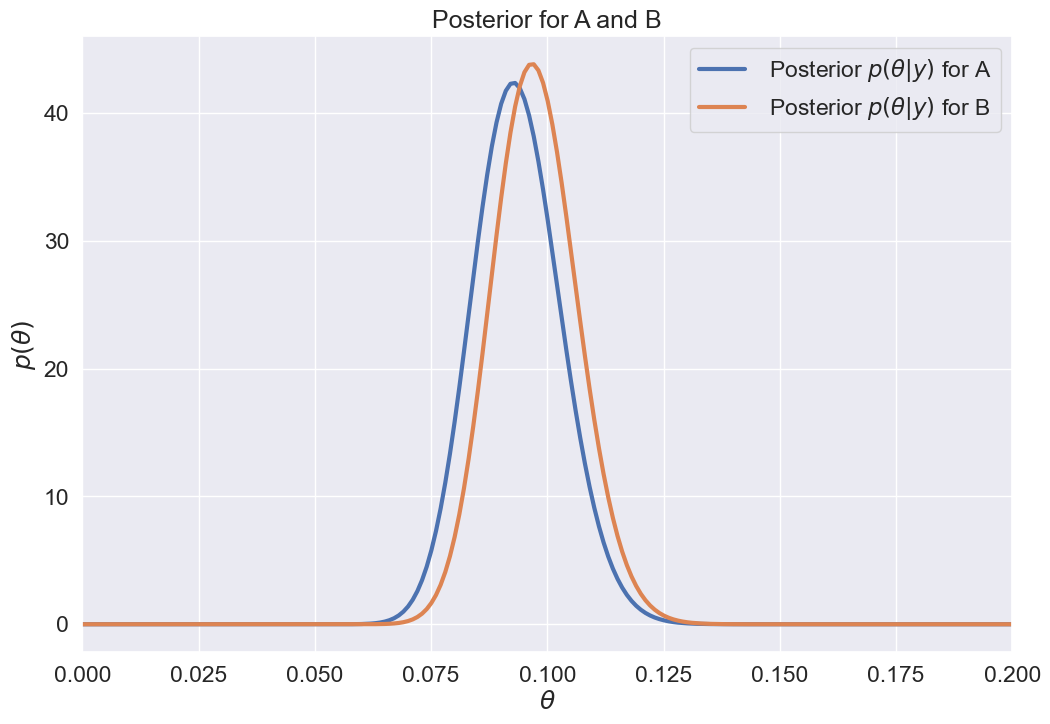

In [31]:
# Define parameters for both ads
N_A = 947  # Number of times ad A was shown
y_A = 87   # Number of clicks for ad A
N_B = 1053 # Number of times ad B was shown
y_B = 101  # Number of clicks for ad B

# Prior parameters (Beta(2,2) for both ads)
a_0, b_0 = 2, 2

# Calculate posterior parameters for ad A
# Posterior is Beta(a_0 + y_A, b_0 + N_A - y_A)
a_A = a_0 + y_A  # New alpha parameter for ad A
b_A = b_0 + N_A - y_A  # New beta parameter for ad A



# Calculate posterior parameters for ad B
# Posterior is Beta(a_0 + y_B, b_0 + N_B - y_B)
a_B = a_0 + y_B  # New alpha parameter for ad B
b_B = b_0 + N_B - y_B  # New beta parameter for ad B

# Create points for plotting
thetas = jnp.linspace(0, 1, 1000)  # 1000 points between 0 and 1

# Calculate distributions for ad A
posterior_ad_A = beta_dist.pdf(thetas, a=a_A, b=b_A)  # Posterior distribution

# Calculate distributions for ad B
posterior_ad_B = beta_dist.pdf(thetas, a=a_B, b=b_B)  # Posterior distribution

# Create plot
plt.figure(figsize=(12, 8))
plt.plot(thetas, posterior_ad_A, label=r' Posterior $p(\theta|y)$ for A')
plt.plot(thetas, posterior_ad_B, label=r' Posterior $p(\theta|y)$ for B')
plt.title(rf'Posterior for A and B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)  # Limit x-axis to [0,0.2]
plt.legend()
plt.show()


**Task 5.2** Estimate the mean and a 95%-credibility interval for both ads. Use a $p(\theta) = \text{Beta}(\theta|2, 2)$ prior for both ads.

In [32]:
# estimating mean of Ad A 
stars()
# print summary of add A 
print(f"Ad A had a total of {N_A} views and {y_A} clicks")
print(f"Prior for Ad A is Beta({a_0}, {b_0})")
print(f"Posterior for Ad A is Beta({a_A}, {b_A})")
mean_ad_A = bernoulli_MLE(y_A, N_A)
print(f"MLE estimate for Ad A is: {mean_ad_A:.4f}")
lower_A, upper_A = confidence_intervals(mean_ad_A, N_A)
print(f"Confidence intervals for Ad A are [{lower_A:.4f}, {upper_A:.4f}]")

stars()

print(f"Ad B had a total of {N_B} views and {y_B} clicks")
print(f"Prior for Ad B is Beta({a_0}, {b_0})")
print(f"Posterior for Ad B is Beta({a_B}, {b_B})")
mean_ad_B = bernoulli_MLE(y_B, N_B)
print(f"MLE estimate for Ad B is: {mean_ad_B:.4f}")
lower_B, upper_B = confidence_intervals(mean_ad_B, N_B)
print(f"Confidence intervals for Ad B are [{lower_B:.4f}, {upper_B:.4f}]")
stars()

****************************************************************************************************
Ad A had a total of 947 views and 87 clicks
Prior for Ad A is Beta(2, 2)
Posterior for Ad A is Beta(89, 862)
MLE estimate for Ad A is: 0.0919
Confidence intervals for Ad A are [0.0735, 0.1103]
****************************************************************************************************
Ad B had a total of 1053 views and 101 clicks
Prior for Ad B is Beta(2, 2)
Posterior for Ad B is Beta(103, 954)
MLE estimate for Ad B is: 0.0959
Confidence intervals for Ad B are [0.0781, 0.1137]
****************************************************************************************************


**Task 5.3** Generate $S = 10000$ posterior samples for both ads and plot the histograms of both sets of samples.




In [33]:
NUM_SAMPLES = 10000

samples_for_add_A = beta_dist.rvs(a=a_A, b=b_A, size=NUM_SAMPLES)

samples_for_add_B = beta_dist.rvs(a=a_B, b=b_B, size=NUM_SAMPLES)

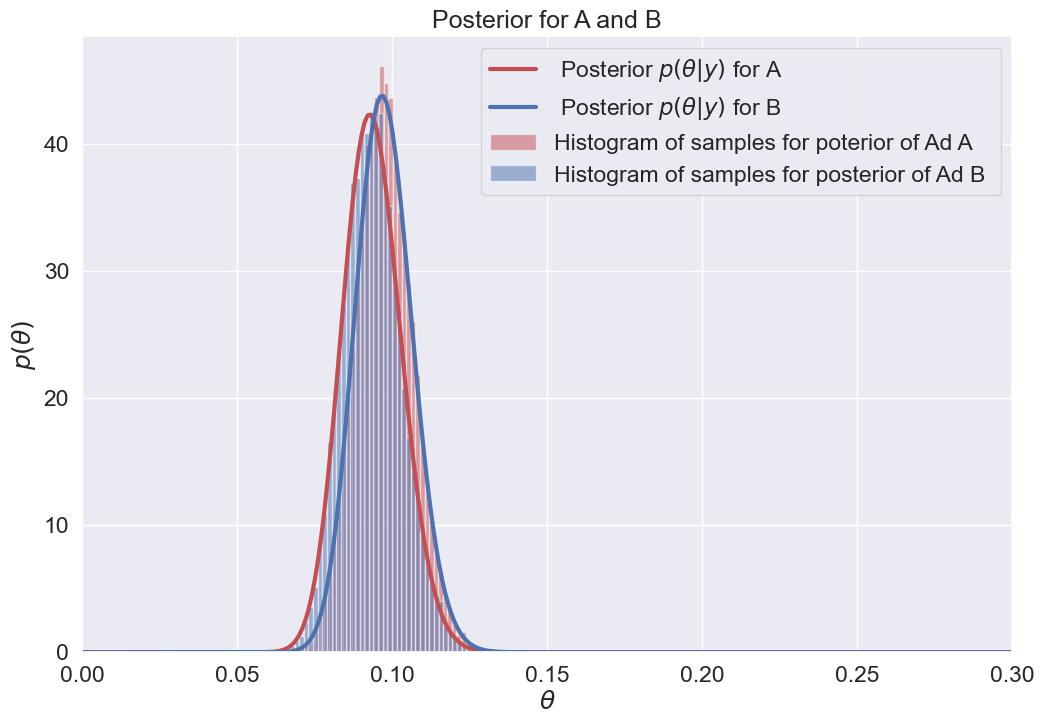

In [ ]:
# Create plot
plt.figure(figsize=(12, 8))
plt.plot(thetas, posterior_ad_A, label=r' Posterior $p(\theta|y)$ for A', color='r')
plt.plot(thetas, posterior_ad_B, label=r' Posterior $p(\theta|y)$ for B', color='b')
plt.hist(samples_for_add_B, density=True, bins=50, label='Histogram of samples for posterior of Ad A', alpha=0.5, color='r')
plt.hist(samples_for_add_A, density=True, bins=50, label='Histogram of samples for posterior of Ad B ', alpha=0.5, color='b')
plt.title(rf'Posterior for A and B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.3)  # Limit x-axis to [0,0.2]
plt.legend()
plt.show()

**Task 5.4** Compute posterior samples for the difference of $\theta_D = \theta_B - \theta_A$ and visualize the histogram

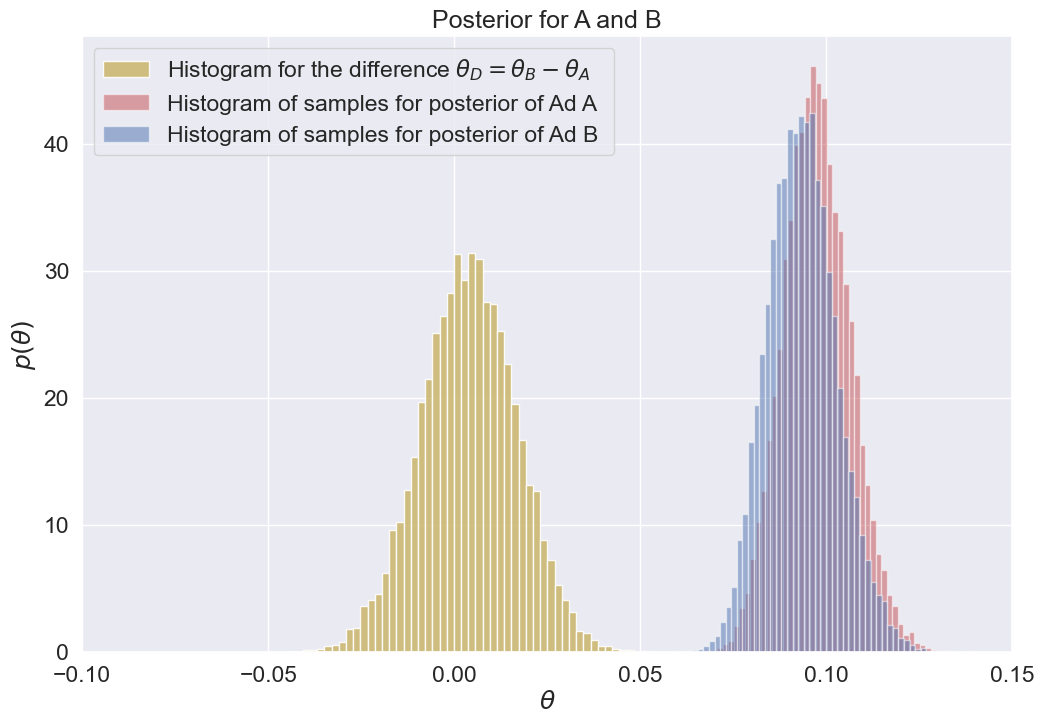

In [93]:
thetas_difference = samples_for_add_B - samples_for_add_A 

# Create plot
plt.figure(figsize=(12, 8))
plt.hist(thetas_difference, density=True, bins=50, alpha=0.9, color='y', label=r"Histogram for the difference $\theta_D =\theta_B - \theta_A$")
plt.hist(samples_for_add_B, density=True, bins=50, label='Histogram of samples for posterior of Ad A', alpha=0.5, color='r')
plt.hist(samples_for_add_A, density=True, bins=50, label='Histogram of samples for posterior of Ad B ', alpha=0.5, color='b')
plt.title(rf'Posterior for A and B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(-0.1, 0.15)  # Limit x-axis to [0,0.2]
#plt.ylim(0, 35)
plt.legend()
plt.show()


**Task 5.5** Compute the posterior mean and 95% credibility interval for $\theta_D$ using the posterior samples


Mean for the Posterior Difference between the Theta_B - Theta_A is 0.003940778784453869
The confidence intervals for the posterior difference is [-0.0218, 0.0290]


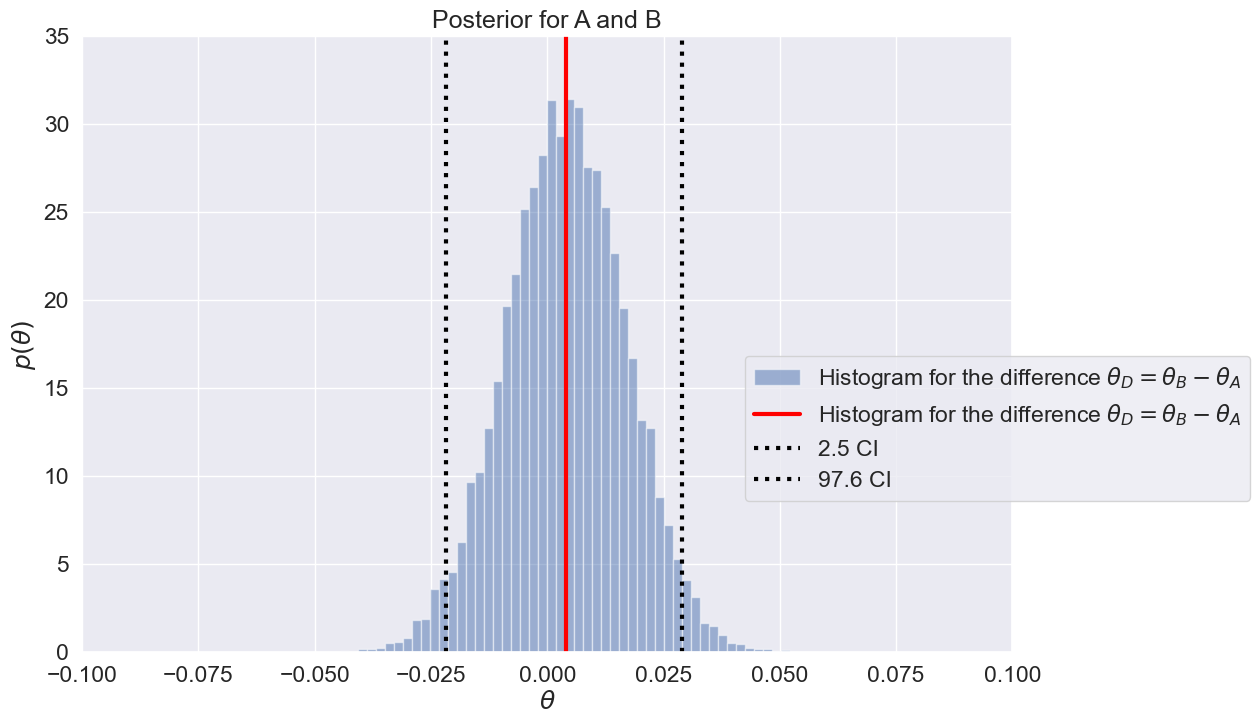

In [94]:
post_dif = jnp.mean(thetas_difference)

N = len(thetas_difference)

intervals = jnp.percentile(thetas_difference, jnp.array([2.5, 97.5]))


print(f"Mean for the Posterior Difference between the Theta_B - Theta_A is {post_dif}")
print(f"The confidence intervals for the posterior difference is [{intervals[0]:.4f}, {intervals[1]:.4f}]")

# Create plot
plt.figure(figsize=(12, 8))
plt.hist(thetas_difference, density=True, bins=50, alpha=0.5, color='b', label=r"Histogram for the difference $\theta_D =\theta_B - \theta_A$")
plt.axvline(post_dif, label=r'Histogram for the difference $\theta_D =\theta_B - \theta_A$', color='red')
plt.axvline(intervals[0], linestyle=':', label='2.5 CI', color='black')
plt.axvline(intervals[1], linestyle=':', label='97.6 CI', color='black')
plt.title(rf'Posterior for A and B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(-0.1, 0.1)
plt.ylim(0, 35)
plt.legend(loc='best', bbox_to_anchor=(0.7, 0.5))
plt.show()




**Task 5.6** What is the posterior probability that the click-rate of version B is larger than click-rate of version A?


In [90]:
print(f"The probability that the click-rate of version B is larger than click-rate of version A is : {jnp.mean(samples_for_add_B > samples_for_add_A) * 100:.2f}%")

The probability that the click-rate of version B is larger than click-rate of version A is : 62.26%
